<h1>Prototyp Frequenzanalyse</h1>
Erstellt am 22.04.2022 von Christian T. Seidler
<br>Zweck: Darstellen der 5 stärksten Frequenzanteile jedes Bearing im Datensatz.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy import fftpack

import matplotlib.pyplot as plt
import time
import os

In [2]:
# Datenpfad anlegen
path = r'D:\HS Albstadt\Sommersemester 2022\Machine Learning in Manufacturing\Projektarbeit\Datensatz\Test_set'

learning_sets = {'Bearing1_1': 2803,
                 'Bearing1_2': 871,
                 'Bearing2_1': 911,
                 'Bearing2_2': 797,
                 'Bearing3_1': 515,
                 'Bearing3_2': 1637}

test_sets = {'Bearing1_3': 1802,
             'Bearing1_4': 1139,
             'Bearing1_5': 2302,
             'Bearing1_6': 2302,
             'Bearing1_7': 1502,
             'Bearing2_3': 1202,
             'Bearing2_4': 612,
             'Bearing2_5': 2002,
             'Bearing2_6': 572,
             'Bearing2_7': 172,
             'Bearing3_3': 352}

In [3]:
# Funktion, um eine Messung einzulesen und als pd.Dataframe zurückzugeben
def read_single_measurement(filepath):
    # Nur die letzten beiden Spalten einlesen, da diese die Messdaten in x- und y-Richtung enthalten
    measurement = pd.read_csv(filepath, sep=',', header=None, usecols=[4, 5])
    
    # Header umbenennen
    measurement.rename(columns={4: 'acc_x', 5: 'acc_y'}, inplace=True)
    
    return measurement

In [4]:
# Funktion, um die FFT anzuwenden
def perform_fft(input_df, windowing=False):
    f_s = 25600
    
    x = list(input_df['acc_x'])
    y = list(input_df['acc_y'])
    
    # Window anlegen
    win_x = np.kaiser(len(x), 5)
    win_y = np.kaiser(len(y), 5)
    
    if windowing:
        X = fftpack.fft(x * win_x)
        freqs_x = fftpack.fftfreq(len(x)) * f_s
        
        Y = fftpack.fft(y * win_y)
        freqs_y = fftpack.fftfreq(len(y)) * f_s
    else:
        # in x-Richtung
        X = fftpack.fft(x)
        freqs_x = fftpack.fftfreq(len(x)) * f_s

        # in y-Richtung
        Y = fftpack.fft(y)
        freqs_y = fftpack.fftfreq(len(y)) * f_s
    
    return X, freqs_x, Y, freqs_y

In [5]:
# Funktion, um die Frequenz mit der größten Magnitude aus dem Frequenzspektrum zu extrahieren
def extract_max_freq(X, freqs_x): 
    # Umwandeln der Eingangsdaten in Listen
    x = list(np.abs(X))
    freqs = list(freqs_x)
    
    # maximale Magnitude bestimmen
    max_x = max(x)
    
    # Index der Frequenz mit der größten Magnitude bestimmen
    index_max_x = x.index(max(x))
    
    # zugehörige Frequenz extrahieren
    max_freq = freqs[index_max_x]
    
    return max_freq

In [6]:
# Funktion, um automatisiert alle Messungen einzulesen und die maximale Frequenz zu extrahiere
def read_bearing_measurements_with_fft(filepath, start=1, end=1, step=1):
    data = pd.DataFrame()
    
    # Filepath automatisiert anpassen
    for i in range(start, end+1, step):        
        if i < 10:
            document = r'\acc_0000' + str(i) + '.csv'
        elif 10 <= i < 100:
            document = r'\acc_000' + str(i) + '.csv'
        elif 100 <= i < 1000:
            document = r'\acc_00' + str(i) + '.csv'
        else:
            document = r'\acc_0' + str(i) + '.csv'
            
        path = filepath + document

        # Messdaten einlesen
        input_df = read_single_measurement(path)
        
        # Extrahieren der maximalen Frequenz aus den Messdaten mittels FFT
        X, freqs_x, Y, freqs_y = perform_fft(input_df, windowing=False)
        
        # Bestimmen der 5 Frequenzanteile mit der größten Magnitude
        # In x-Richtung
        # Quelle: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        max_freqs_index_x = np.argpartition(np.abs(X), -10)[-10:]
        max_freqs_value_x = freqs_x[max_freqs_index_x]
        max_freqs_value_x = max_freqs_value_x[np.argsort(freqs_x[max_freqs_index_x])]
        max_freqs_list_x = list(max_freqs_value_x)
        # Negative Frequenzen entfernen
        del max_freqs_list_x[0:5]
        
        # In y-Richtung
        max_freqs_index_y = np.argpartition(np.abs(Y), -10)[-10:]
        max_freqs_value_y = freqs_y[max_freqs_index_y]
        max_freqs_value_y = max_freqs_value_y[np.argsort(freqs_y[max_freqs_index_y])]
        max_freqs_list_y = list(max_freqs_value_y)
        # Negative Frequenzen entfernen
        del max_freqs_list_y[0:5]
        
        # Maximale Frequenzen in DataFrame umwandeln
        frequency_df = pd.DataFrame({'Observation': [], 'max_freq_1_x': [], 'max_freq_2_x': [], 'max_freq_3_x': [],
                                     'max_freq_4_x': [], 'max_freq_5_x': [], 'max_freq_1_y': [], 'max_freq_2_y': [],
                                     'max_freq_3_y': [], 'max_freq_4_y': [], 'max_freq_5_y': []})
        frequency_df.loc[0] = [i, max_freqs_list_x[-1], max_freqs_list_x[-2], max_freqs_list_x[-3],
                               max_freqs_list_x[-4], max_freqs_list_x[-5], max_freqs_list_y[-1],
                               max_freqs_list_y[-2], max_freqs_list_y[-3], max_freqs_list_y[-4],
                               max_freqs_list_y[-5]]
        
        # Anhängen der Daten an den DataFrame
        data = pd.concat([data, frequency_df], ignore_index=True)
        
    return data    

In [12]:
# Funktion, um grundlegende Informationen eines Dataframes auszugeben
def print_df_infos(df):
    print(df.describe(), end='\n\n')
    # print(df.head(), end='\n\n')
    # print(df.tail(), end='\n\n')
    print(df.info(), end='\n\n')

In [8]:
# Funktion, um die berechneten Signalparameter grafisch anzuzeigen
def plot_frequencies(df, figsize=(24, 8)):
    # Maximaler Frequenzanteil
    %matplotlib inline
    df.plot(x='Observation', y=['max_freq_1_x', 'max_freq_1_y'], title='Frequenzanteil mit der größten Magnitude',
            legend=True, figsize=figsize, subplots=True)
    plt.show()

    # Grafische Darstellung der 5 stärksten Frequenzanteile
    # in x-Richtung
    %matplotlib inline
    df.plot(x='Observation', y=['max_freq_1_x', 'max_freq_2_x', 'max_freq_3_x', 'max_freq_4_x', 'max_freq_5_x'], 
            title='Frequenzanteil mit der größten Magnitude in x-Richtung',
            legend=True, figsize=figsize, subplots=True)
    plt.show()

    # in y-Richtung
    # %matplotlib notebook
    %matplotlib inline
    df.plot(x='Observation', y=['max_freq_1_y', 'max_freq_2_y', 'max_freq_3_y', 'max_freq_4_y', 'max_freq_5_y'], 
            title='Frequenzanteil mit der größten Magnitude in y-Richtung',
            legend=True, figsize=figsize, subplots=True)
    plt.show()

In [ ]:
file = os.path.join(path, 'Learning_set', 'Bearing1_1')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements(file, start=1, end=learning_sets['Bearing1_1'])
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
print_df_infos(data)

<h3>Condition 1</h3>

<h5>Bearing 1_1 (Lernset)</h5>

In [17]:
file = os.path.join(path, 'Learning_set', 'Bearing1_1')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=learning_sets['Bearing1_1'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 31.090022325515747



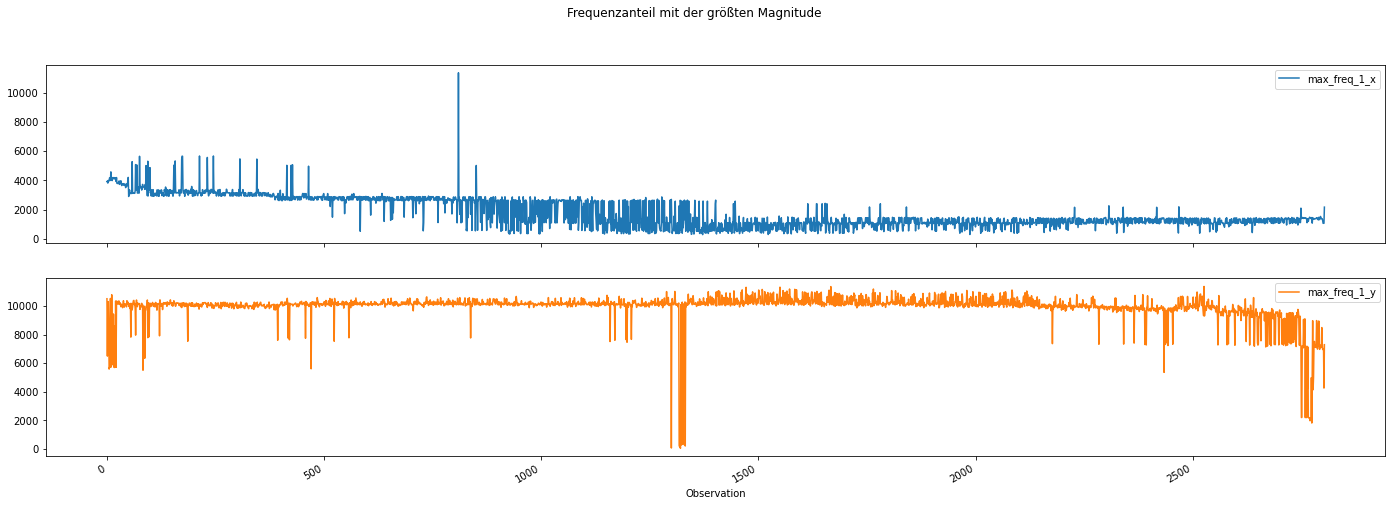

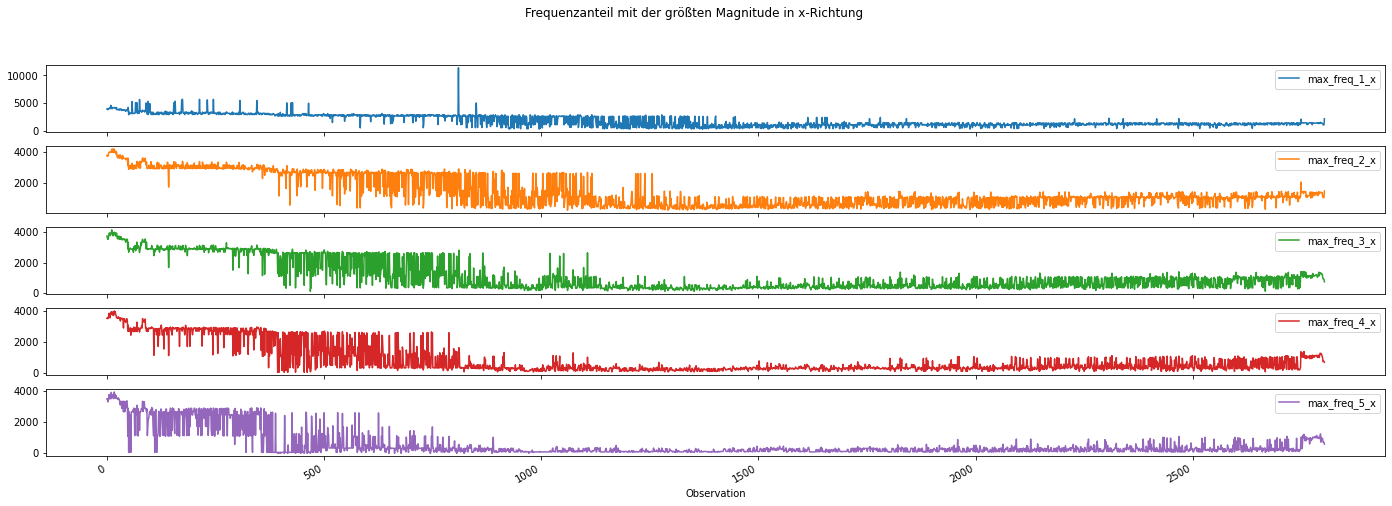

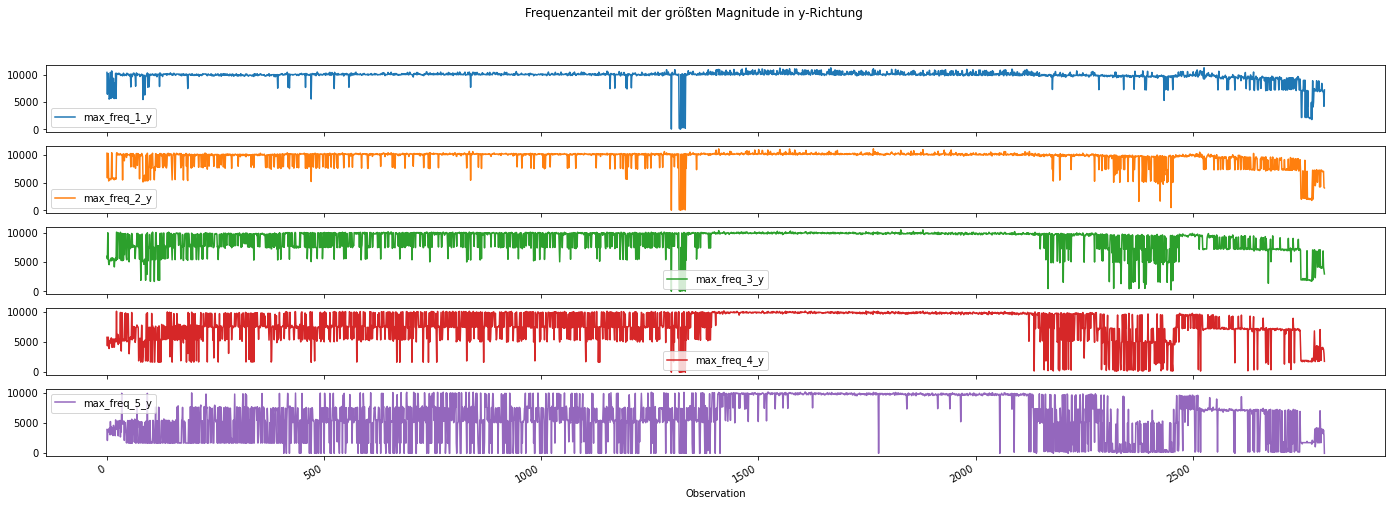

In [18]:
plot_frequencies(data)

<h5>Bearing 1_2 (Lernset)</h5>

In [19]:
file = os.path.join(path, 'Learning_set', 'Bearing1_2')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=learning_sets['Bearing1_2'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 9.595378637313843



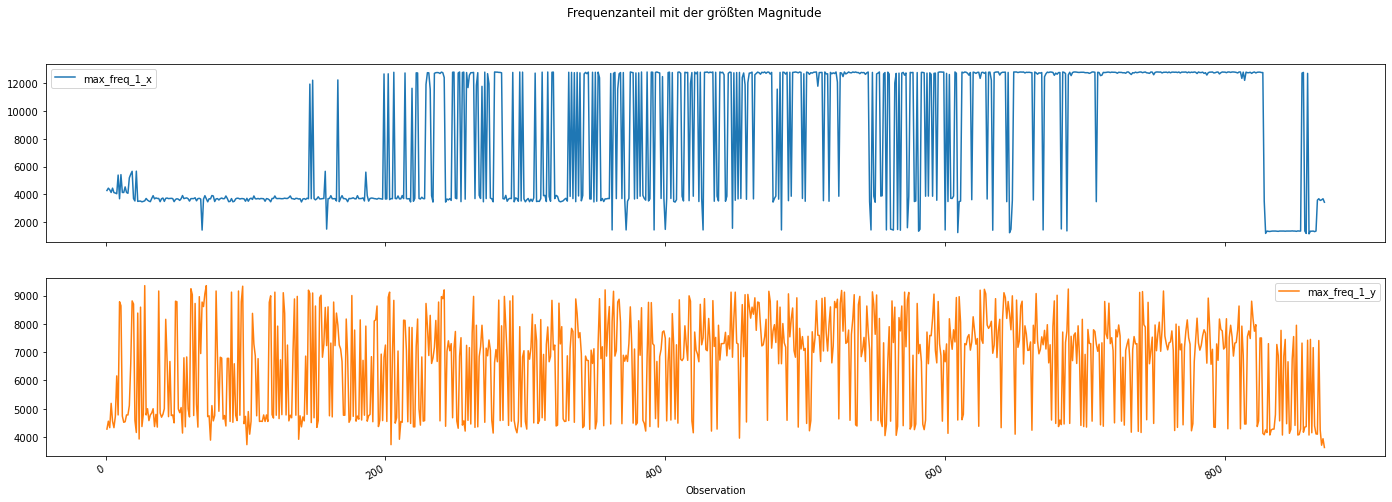

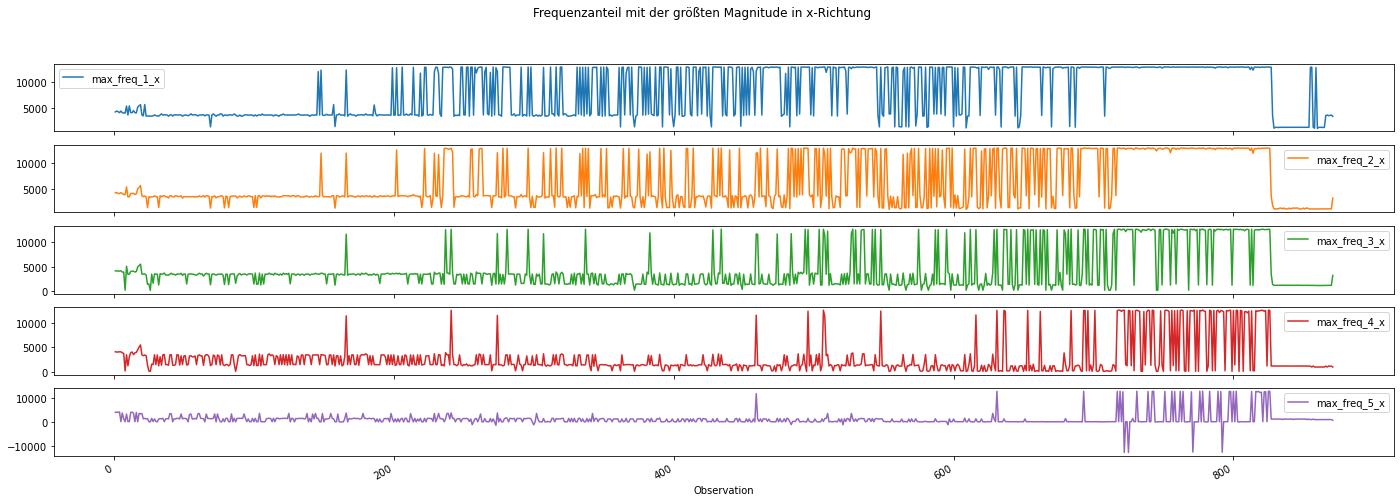

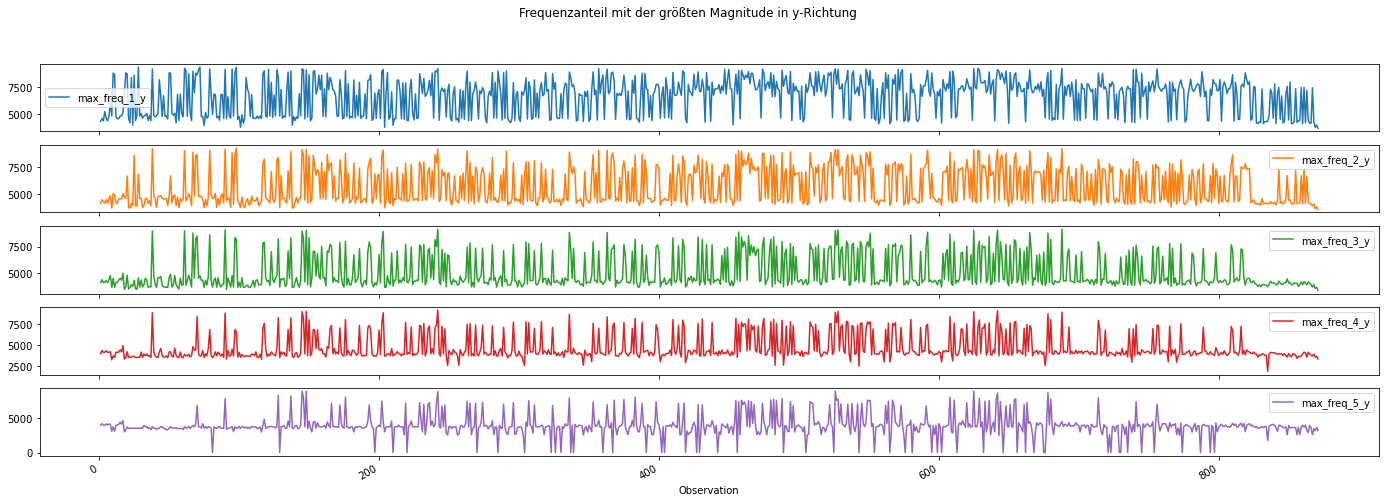

In [20]:
plot_frequencies(data)

<h5>Bearing 1_3 (Testset)</h5>

In [21]:
file = os.path.join(path, 'Test_set', 'Bearing1_3')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing1_3'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 31.6642963886261



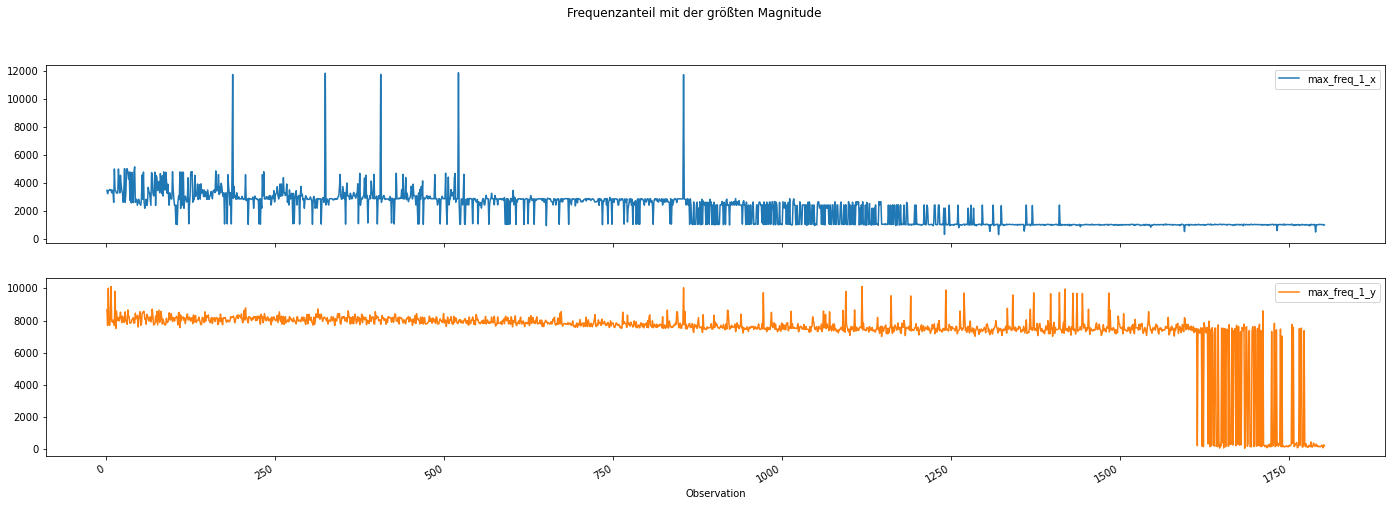

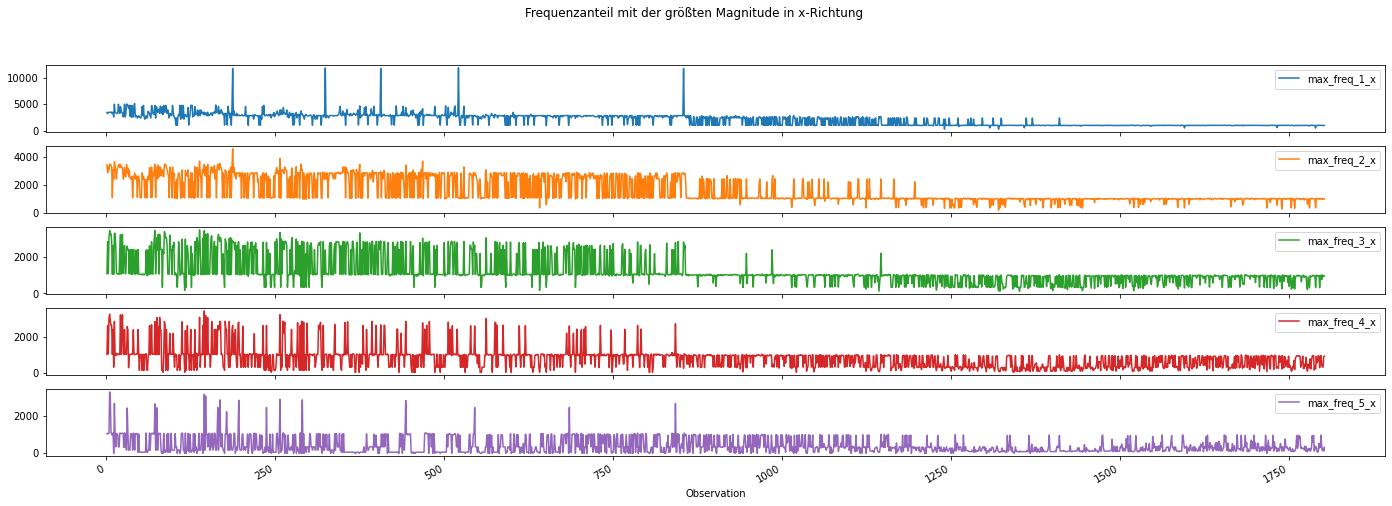

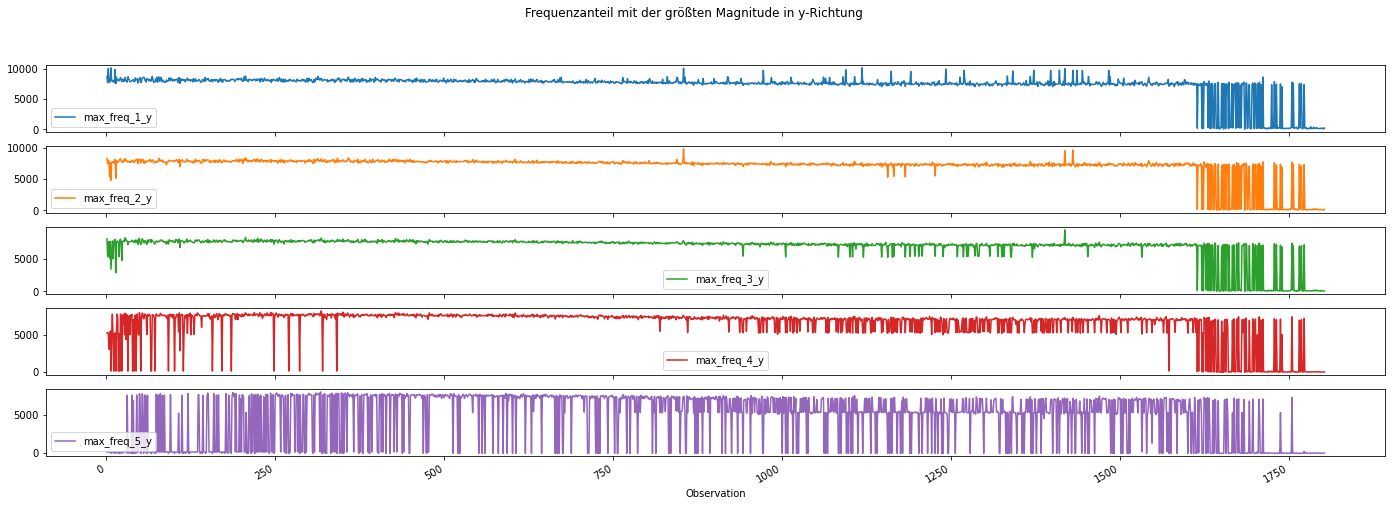

In [22]:
plot_frequencies(data)

<h5>Bearing 1_4 (Testset)</h5>

In [23]:
file = os.path.join(path, 'Test_set', 'Bearing1_4')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing1_4'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 17.588788509368896



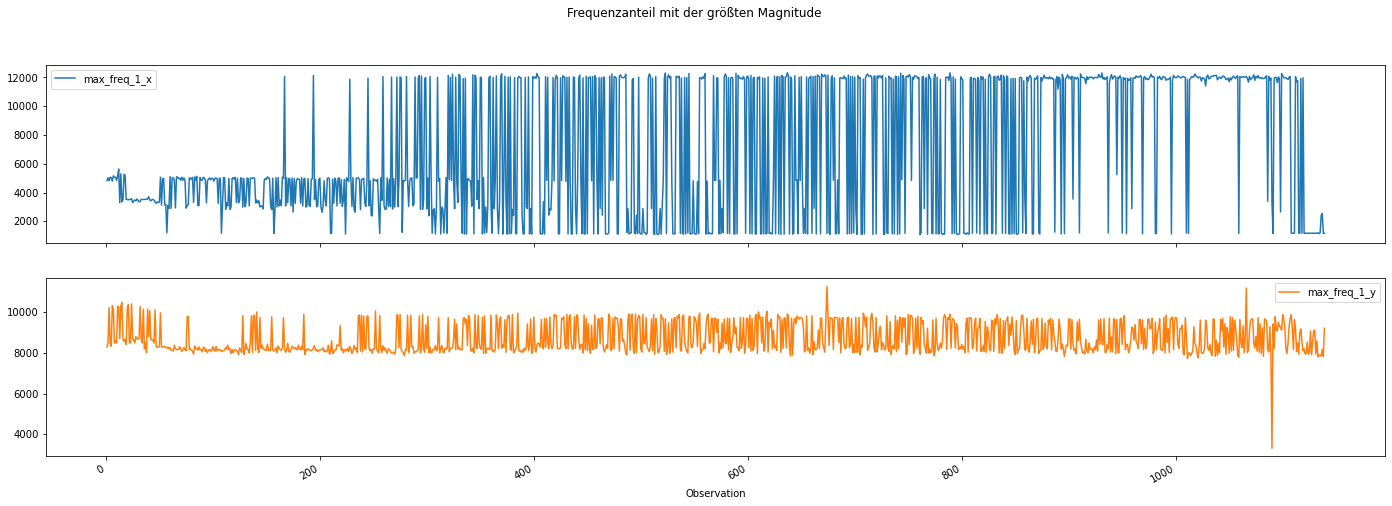

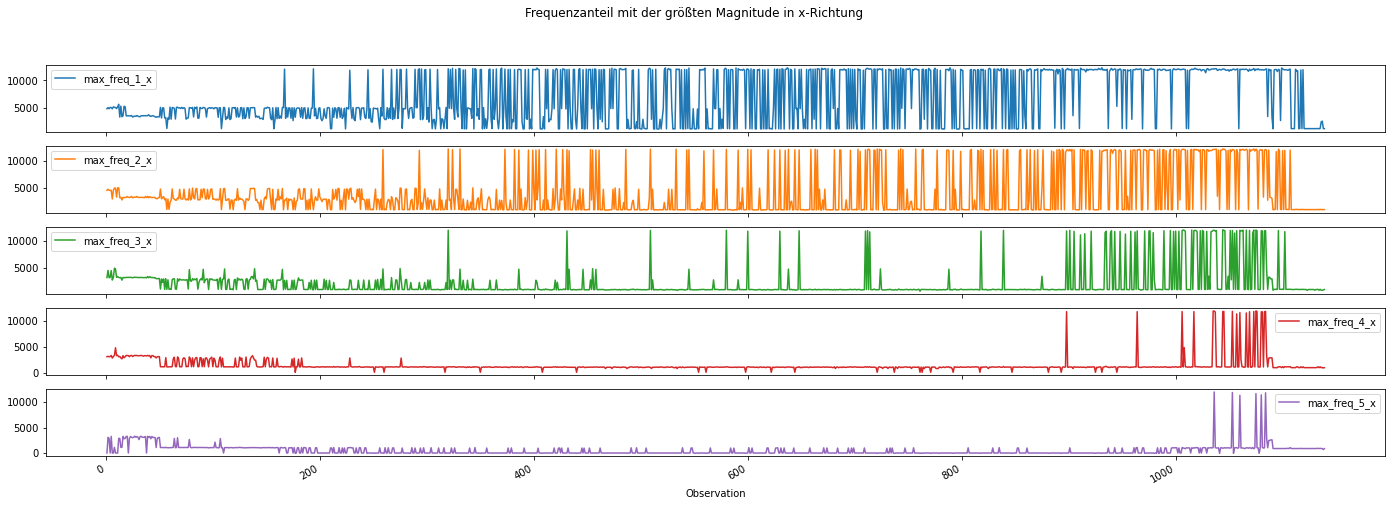

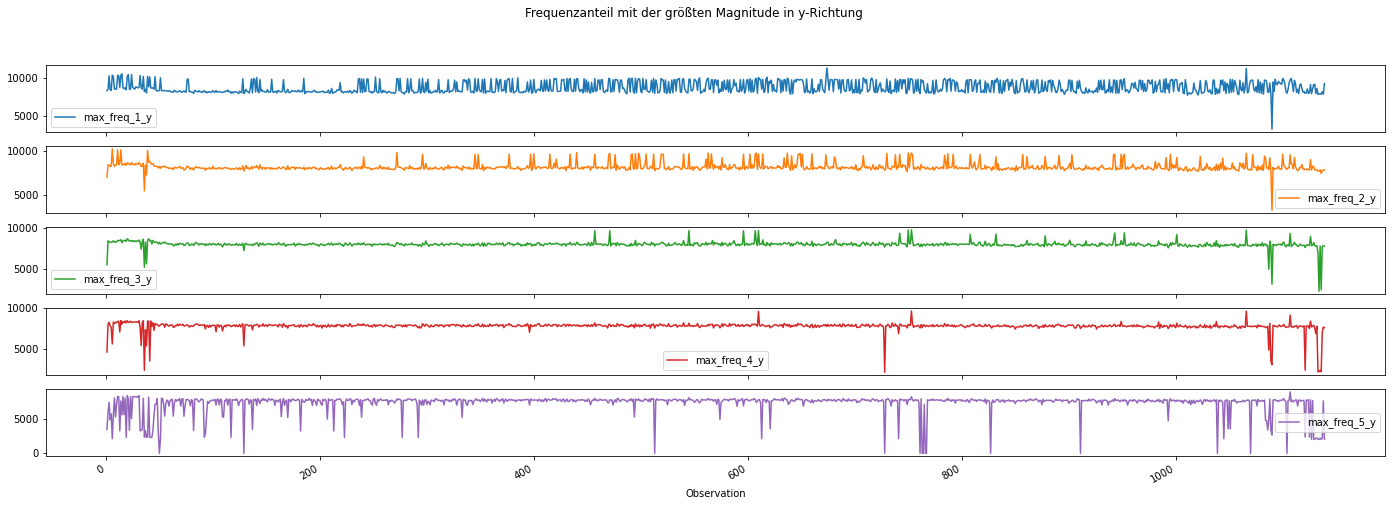

In [24]:
plot_frequencies(data)

<h5>Bearing 1_5 (Testset)</h5>

In [25]:
file = os.path.join(path, 'Test_set', 'Bearing1_5')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing1_5'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 36.326935052871704



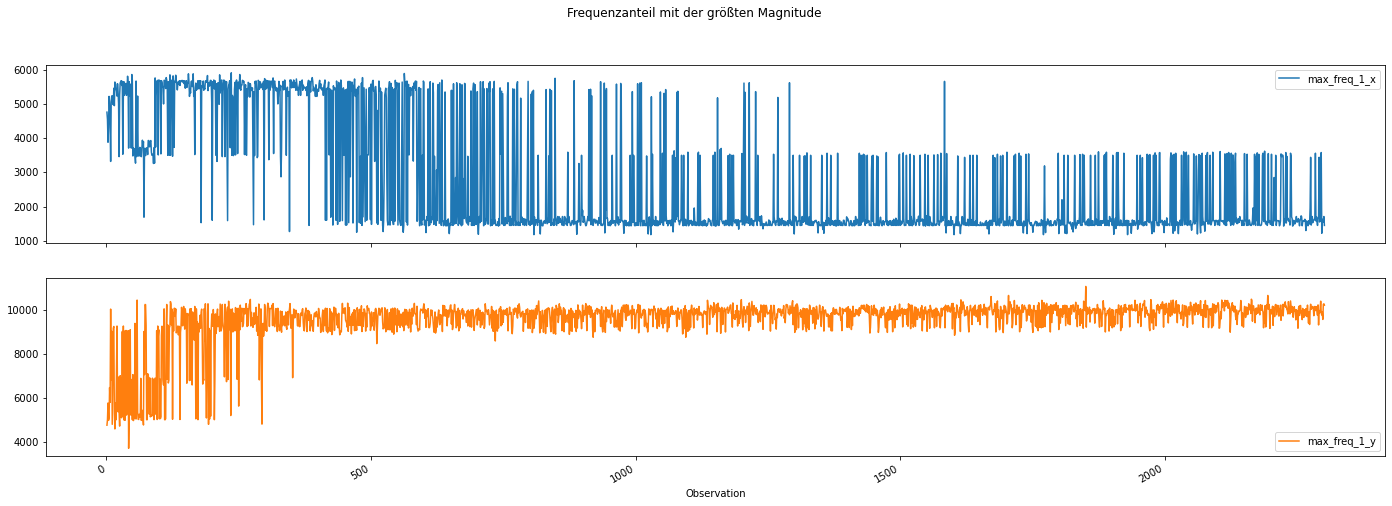

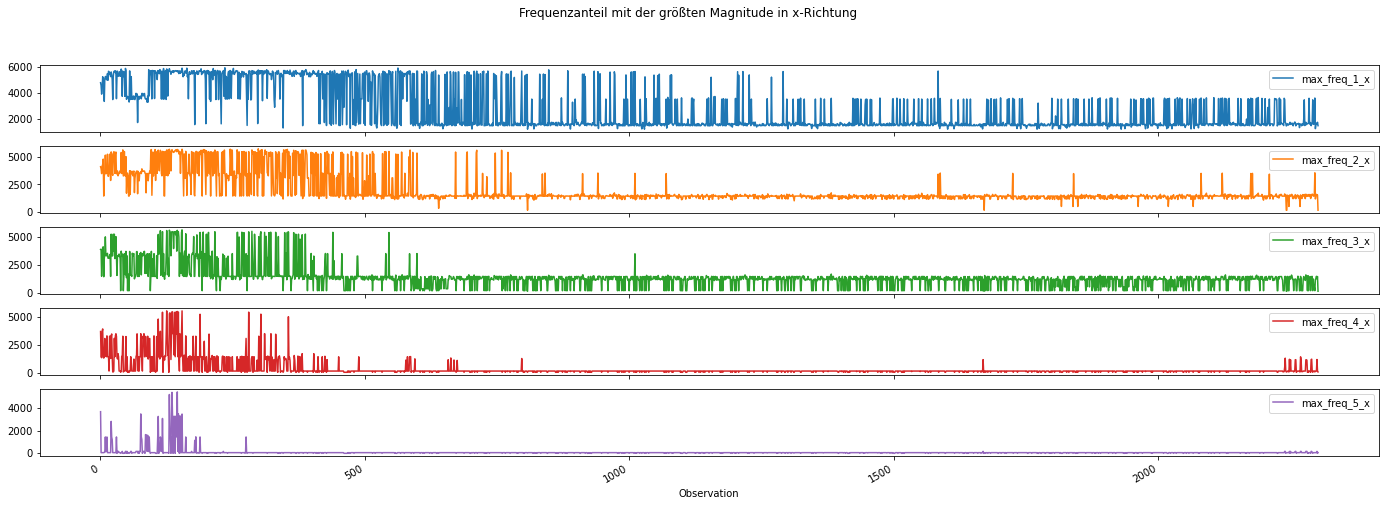

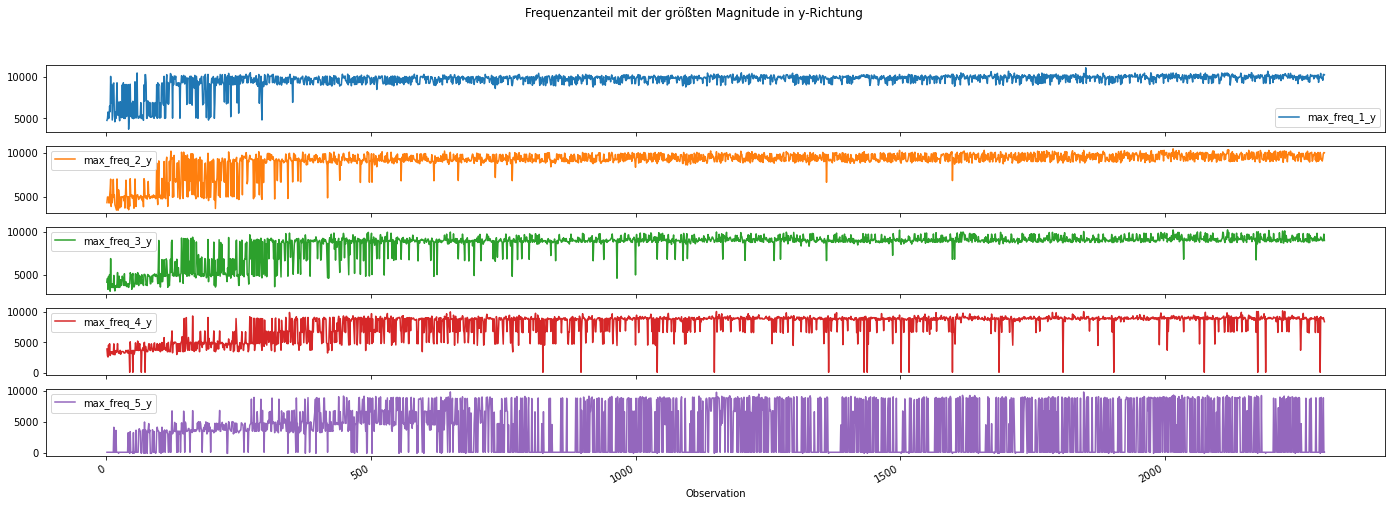

In [26]:
plot_frequencies(data)

<h5>Bearing 1_6 (Testset)</h5>

In [27]:
file = os.path.join(path, 'Test_set', 'Bearing1_6')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing1_6'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 38.48825716972351



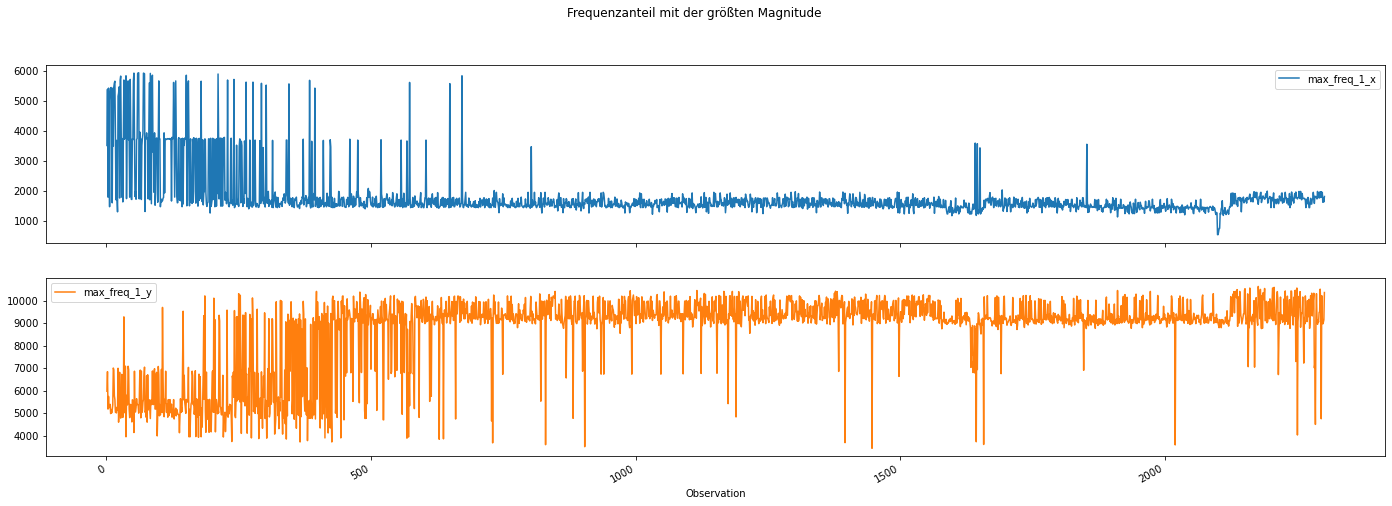

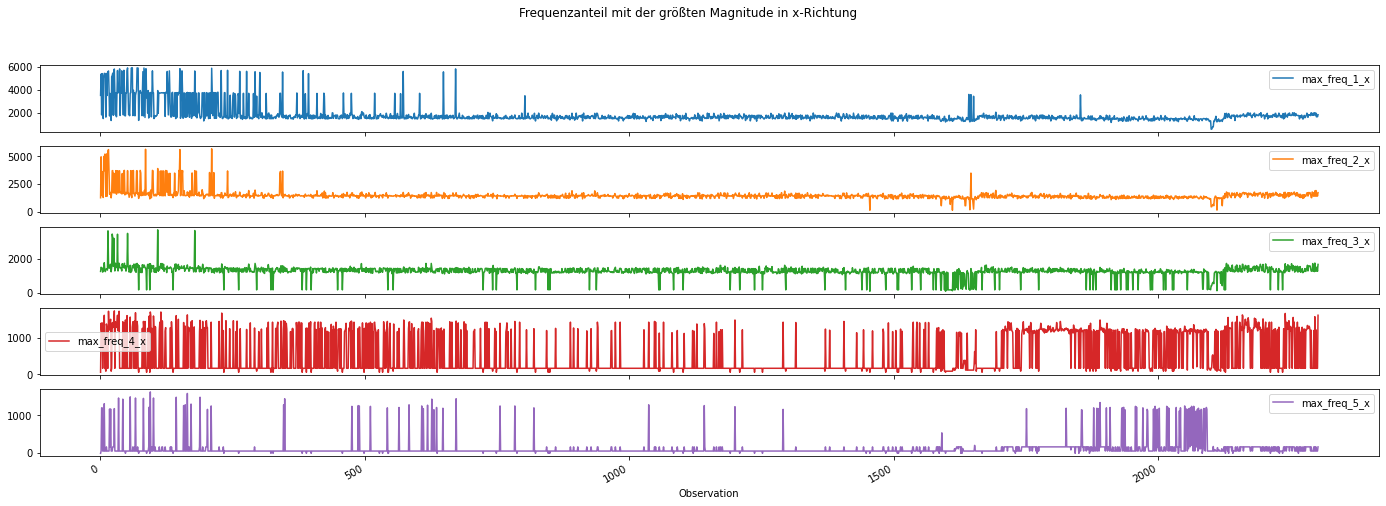

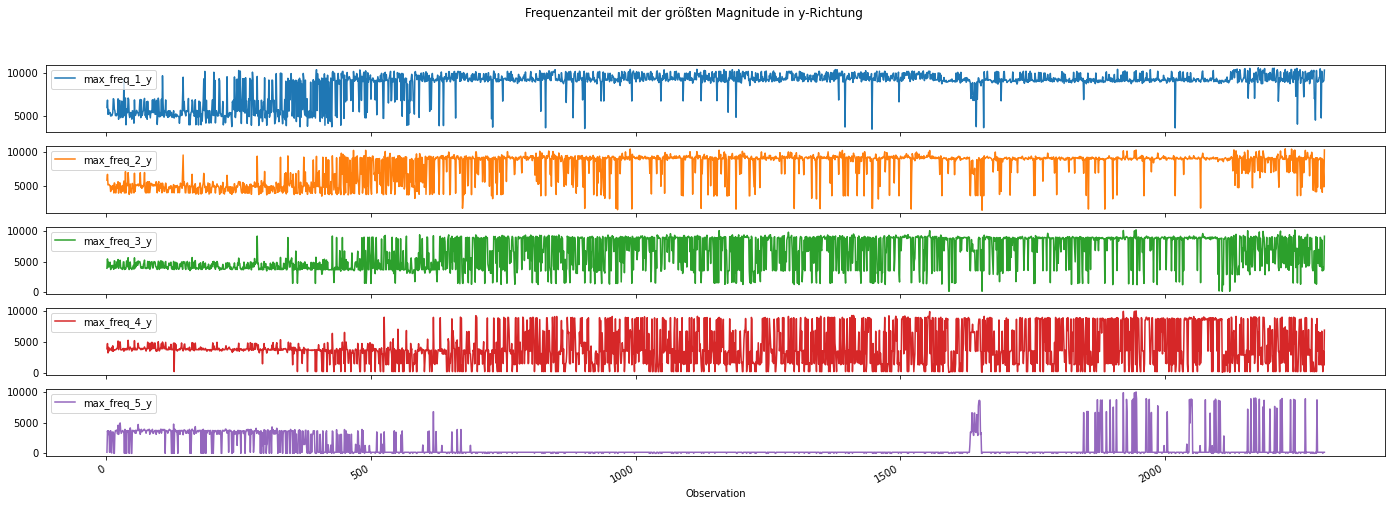

In [28]:
plot_frequencies(data)

<h5>Bearing 1_7 (Testset)</h5>

In [29]:
file = os.path.join(path, 'Test_set', 'Bearing1_7')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing1_7'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 22.489697217941284



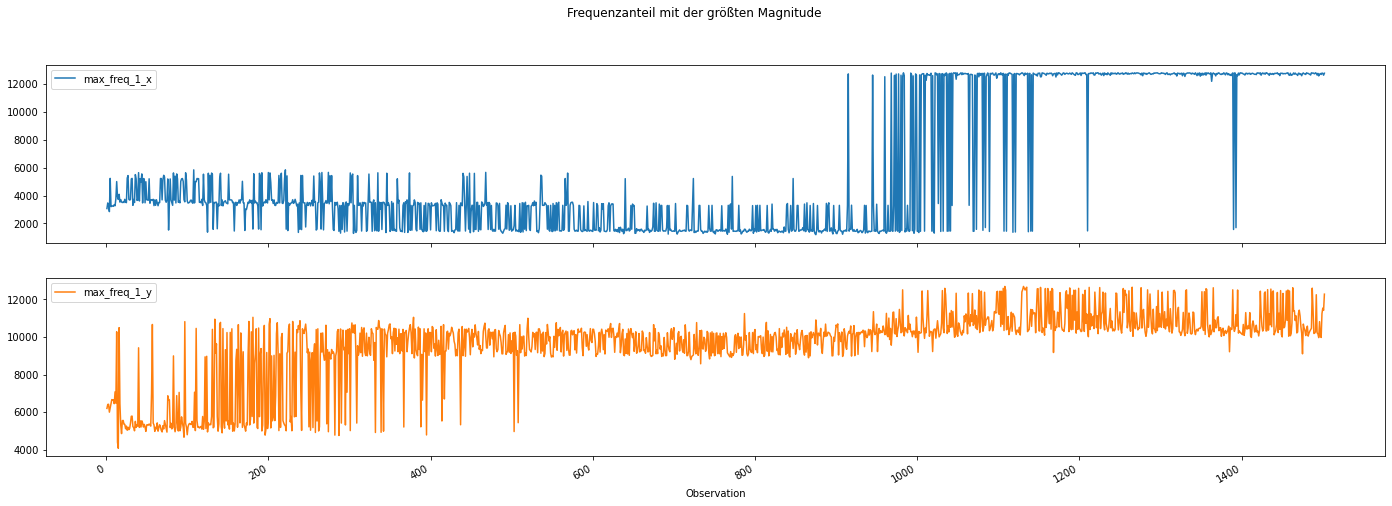

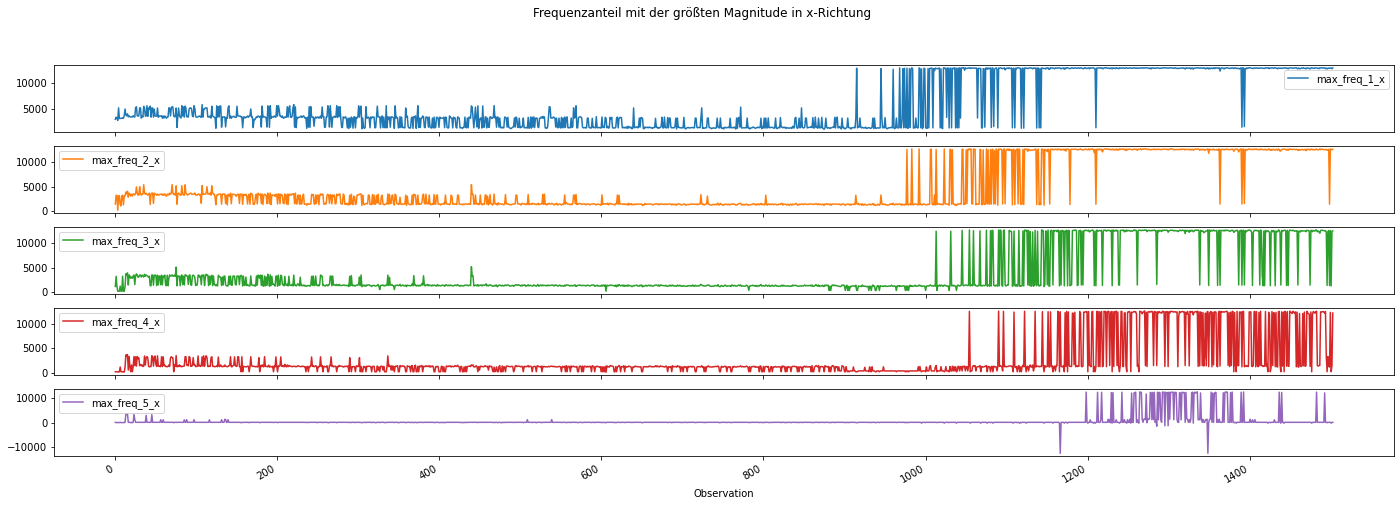

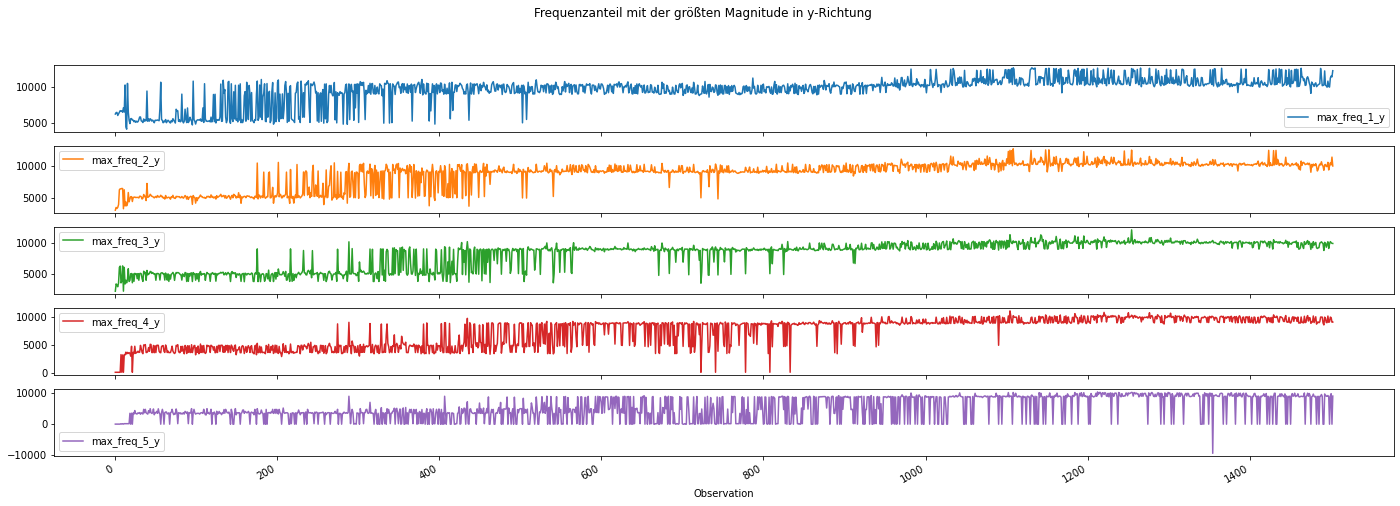

In [30]:
plot_frequencies(data)

<h3>Condition 2</h3>

<h5>Bearing 2_1 (Lernset)</h5>

In [31]:
file = os.path.join(path, 'Learning_set', 'Bearing2_1')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=learning_sets['Bearing2_1'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 14.694946050643921



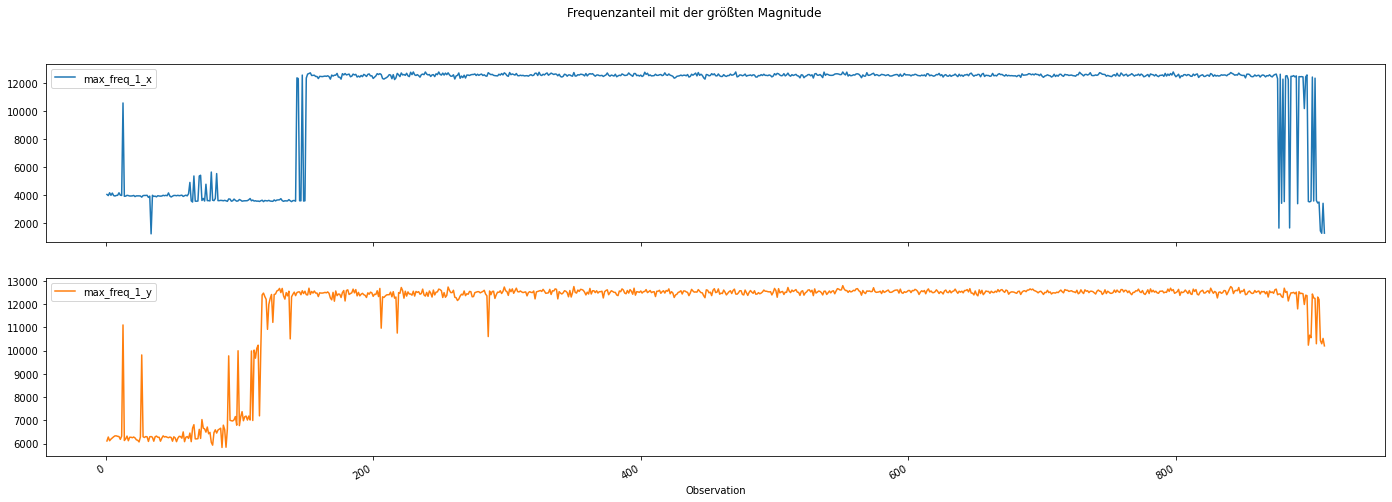

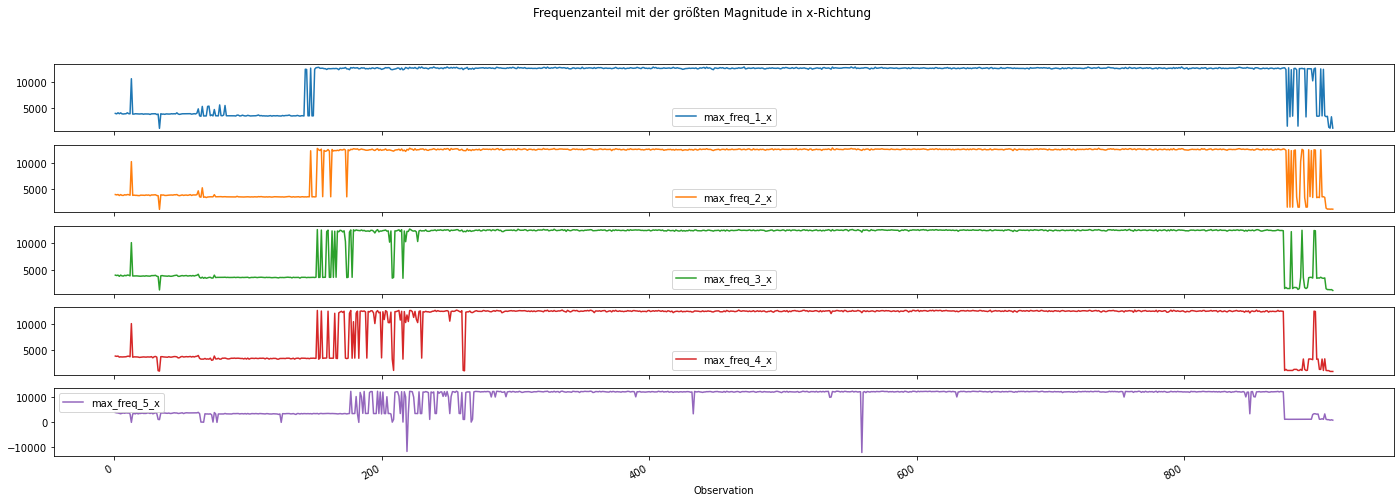

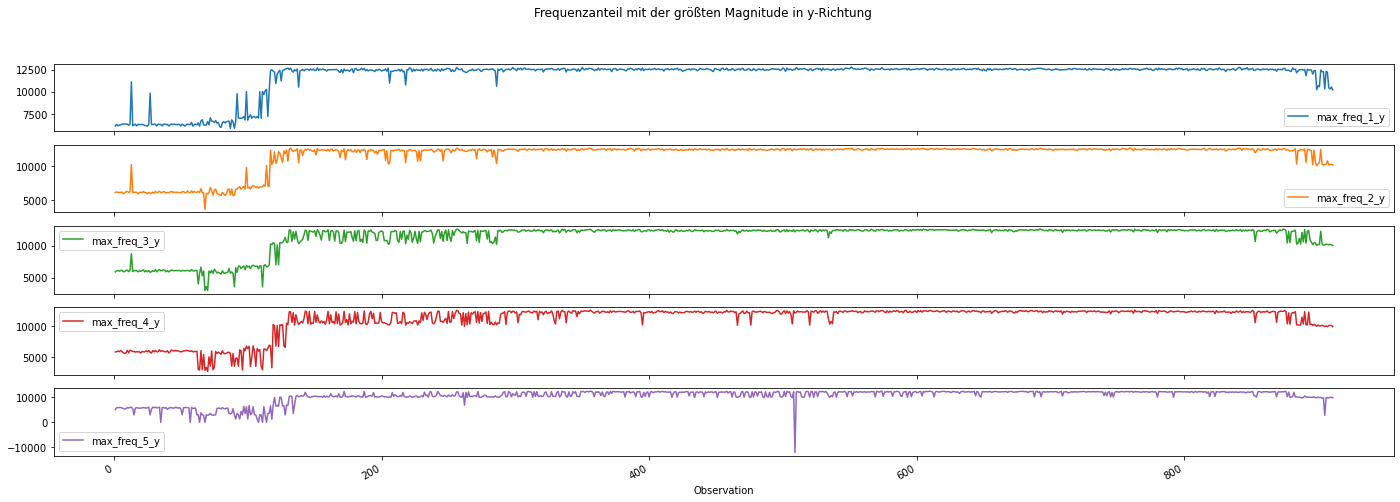

In [32]:
plot_frequencies(data)

<h5>Bearing 2_2 (Lernset)</h5>

In [33]:
file = os.path.join(path, 'Learning_set', 'Bearing2_2')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=learning_sets['Bearing2_2'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 12.677902460098267



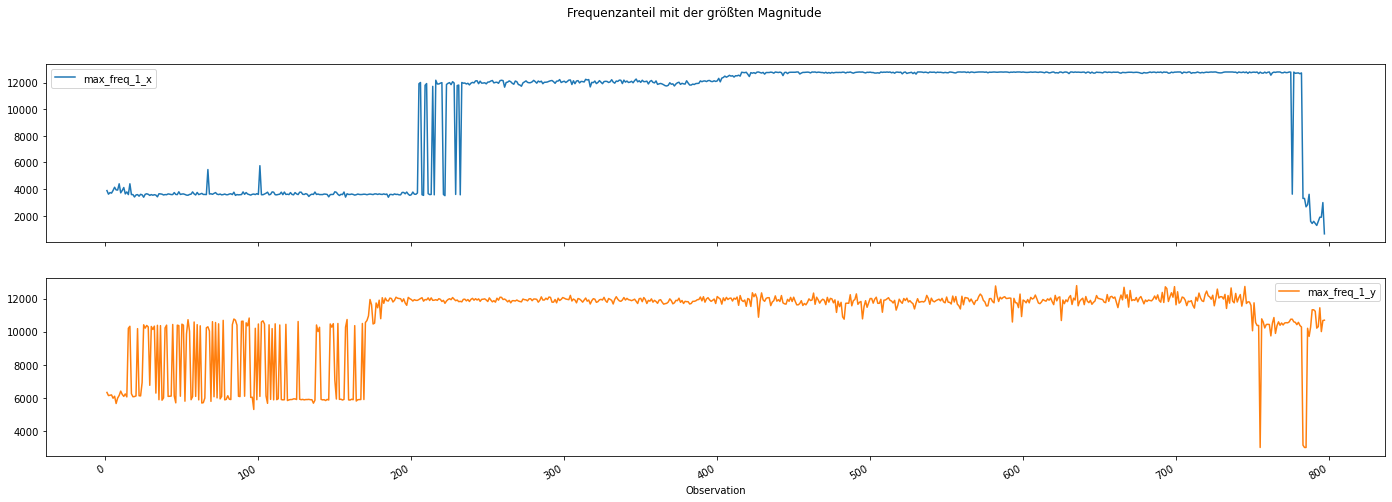

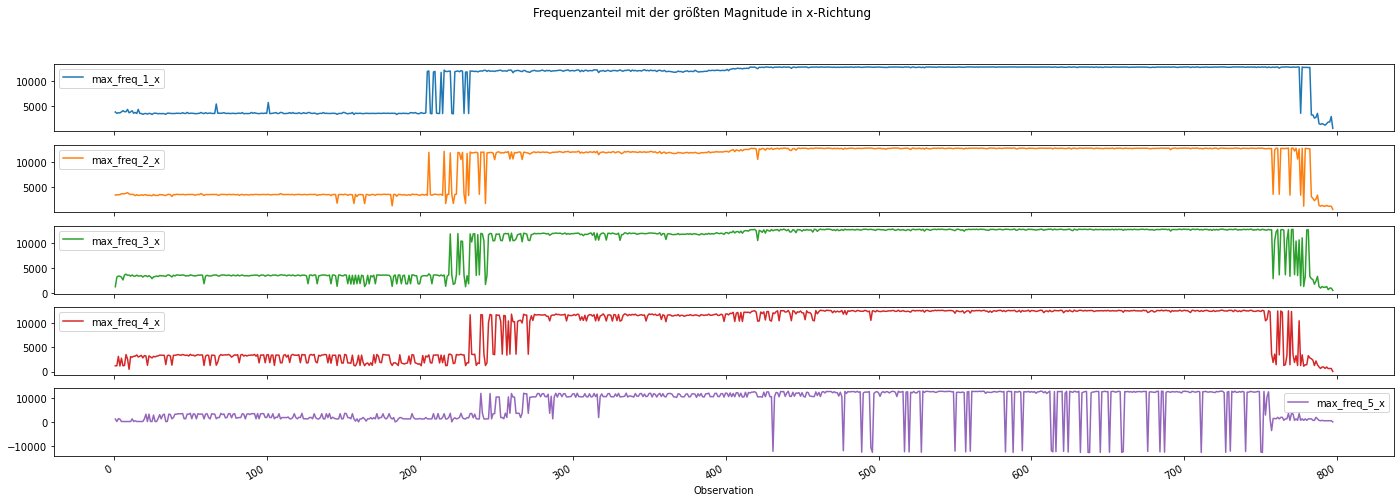

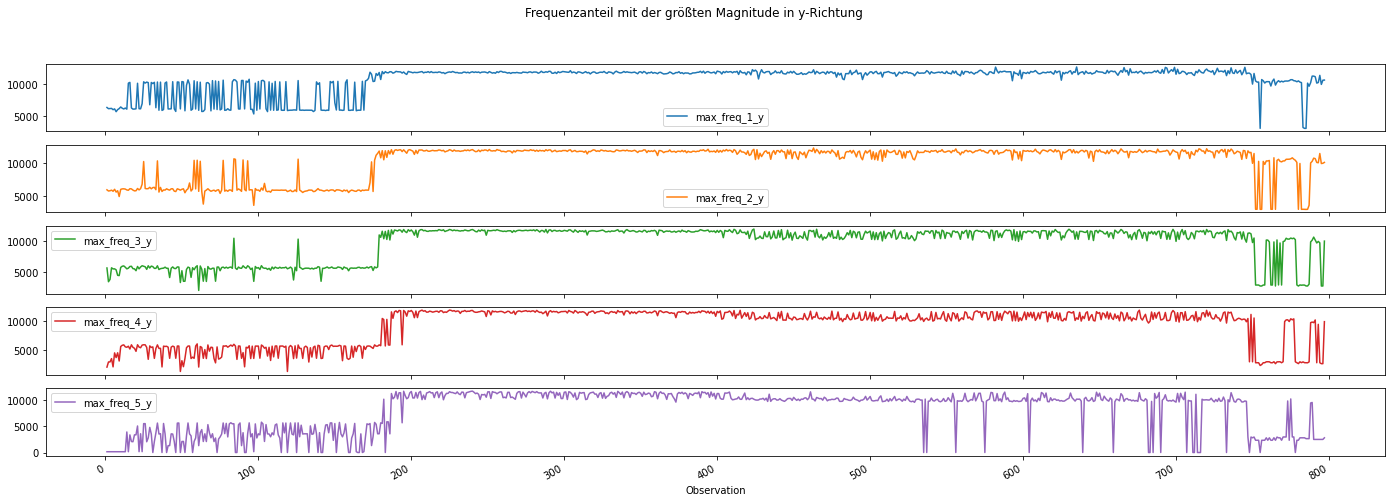

In [34]:
plot_frequencies(data)

<h5>Bearing 2_3 (Testset)</h5>

In [35]:
file = os.path.join(path, 'Test_set', 'Bearing2_3')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing2_3'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 19.46607494354248



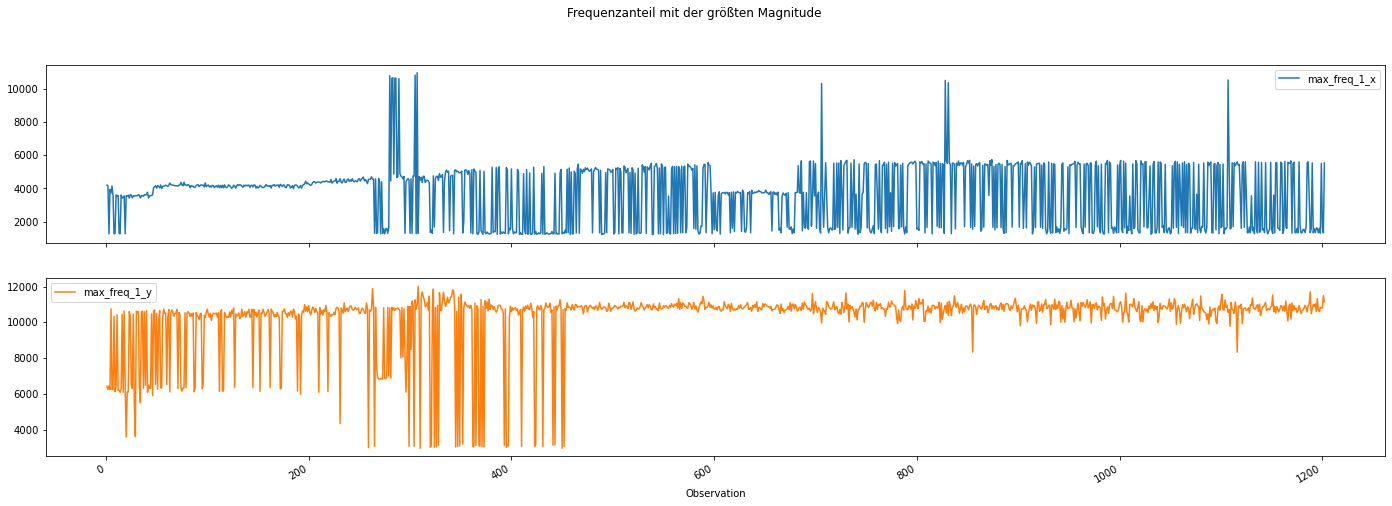

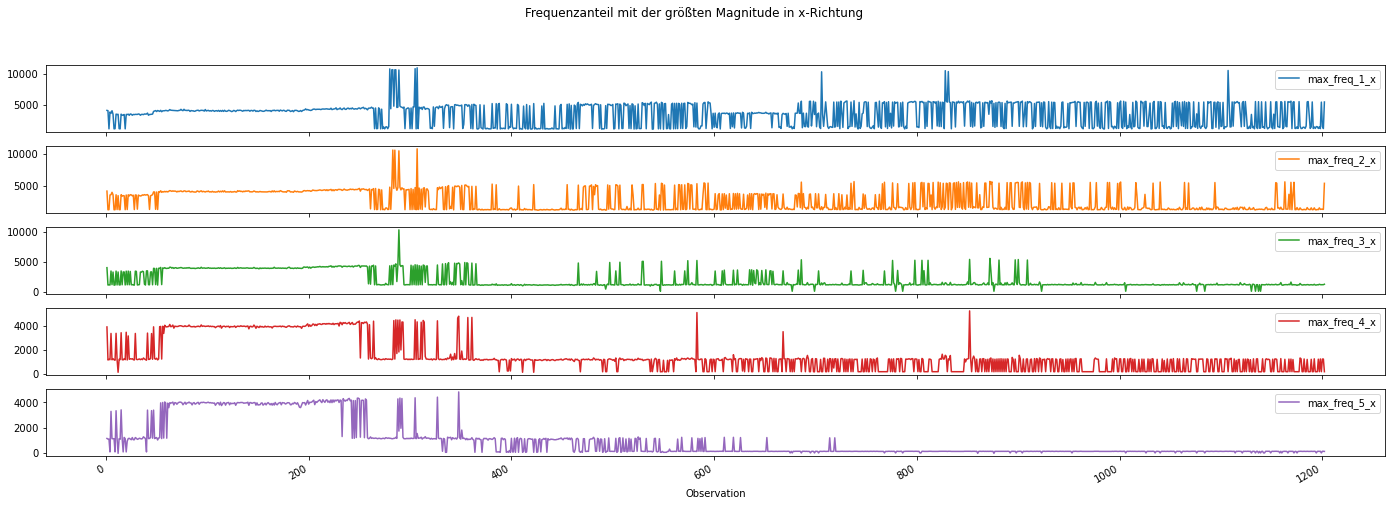

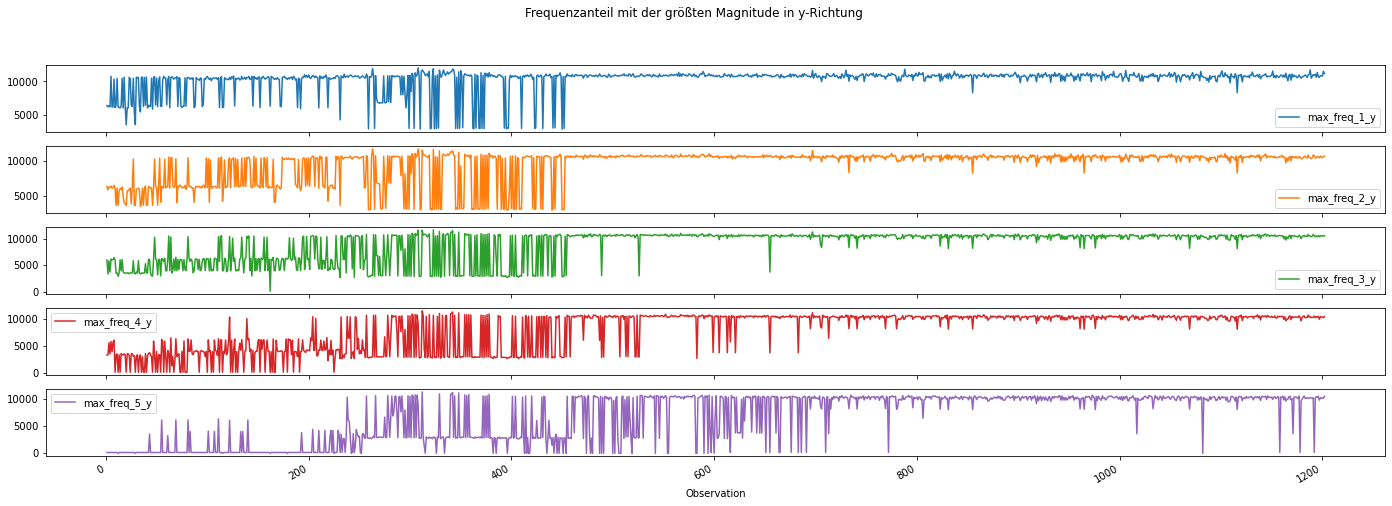

In [36]:
plot_frequencies(data)

<h5>Bearing 2_4 (Testset)</h5>

In [37]:
file = os.path.join(path, 'Test_set', 'Bearing2_4')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing2_4'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 9.54186463356018



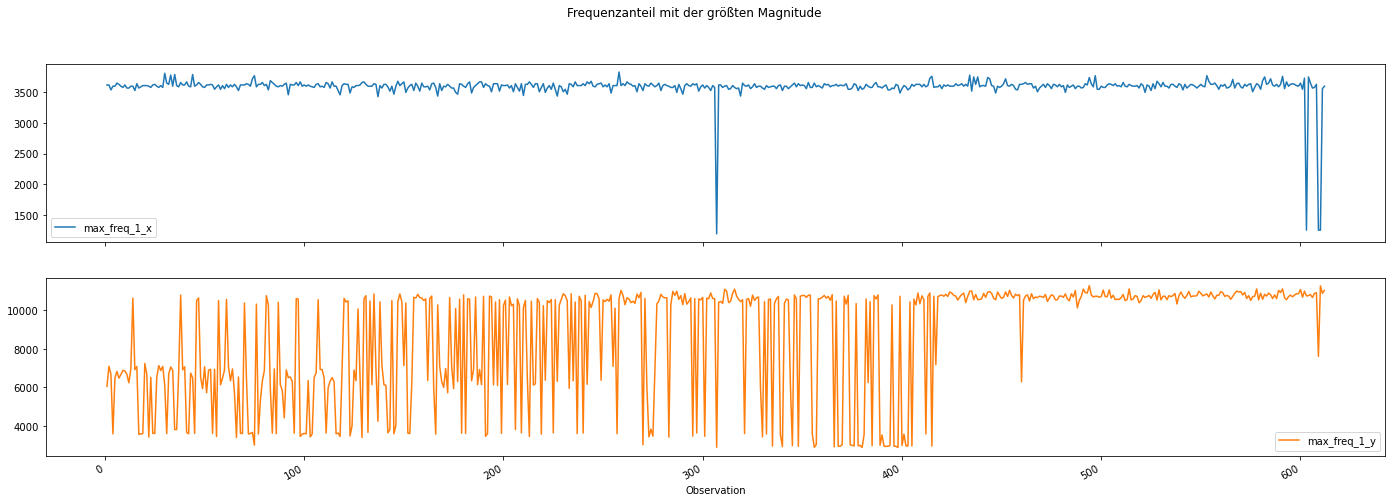

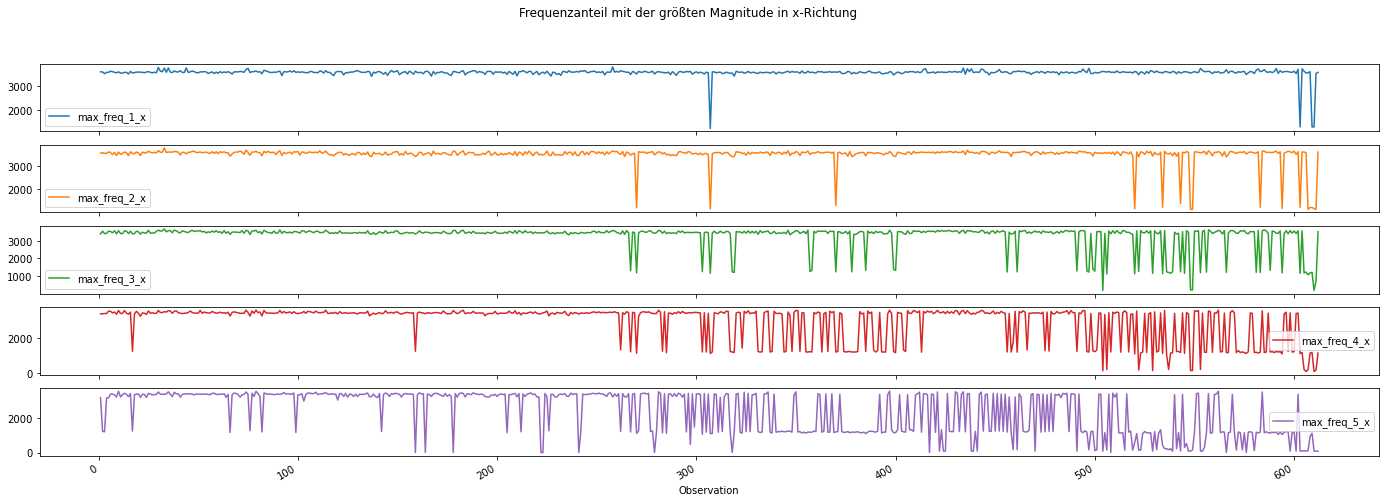

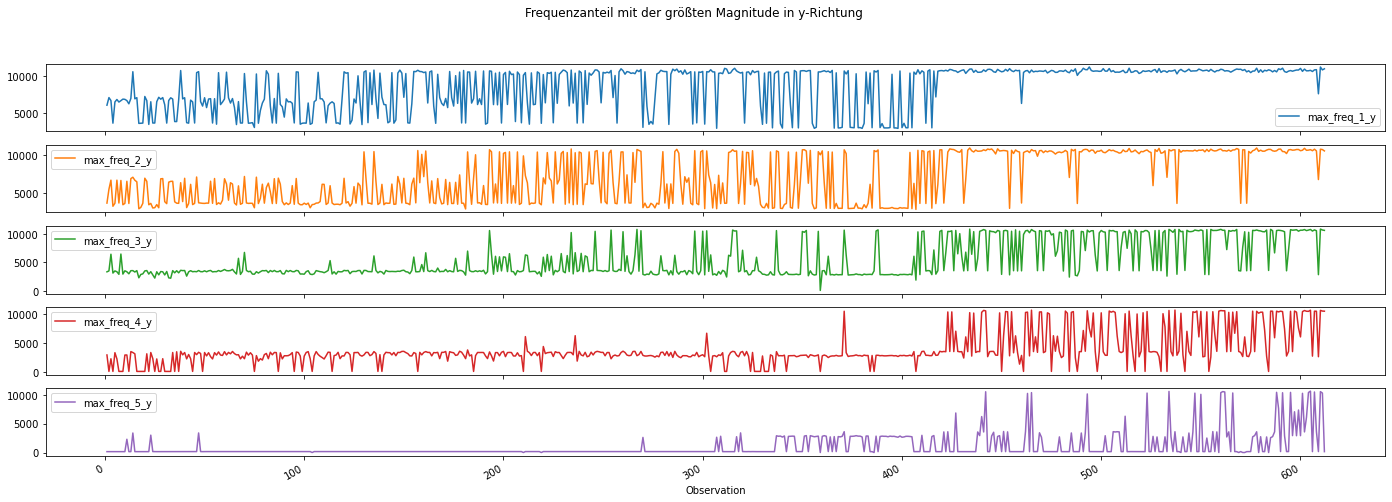

In [38]:
plot_frequencies(data)

<h5>Bearing 2_5 (Testset)</h5>

In [39]:
file = os.path.join(path, 'Test_set', 'Bearing2_5')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing2_5'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 33.07843565940857



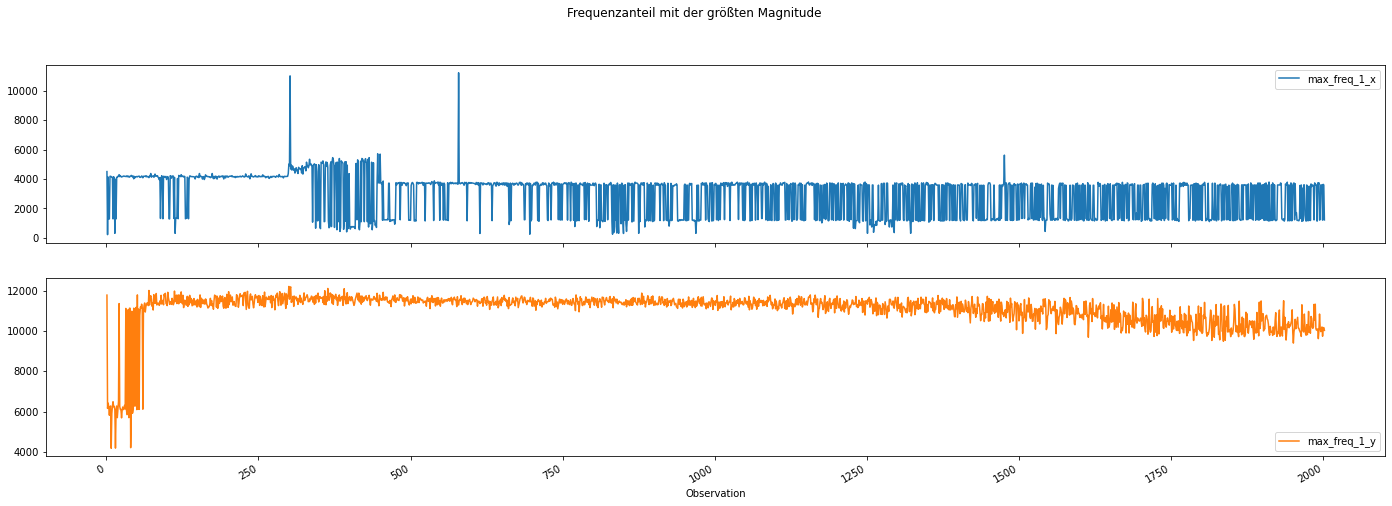

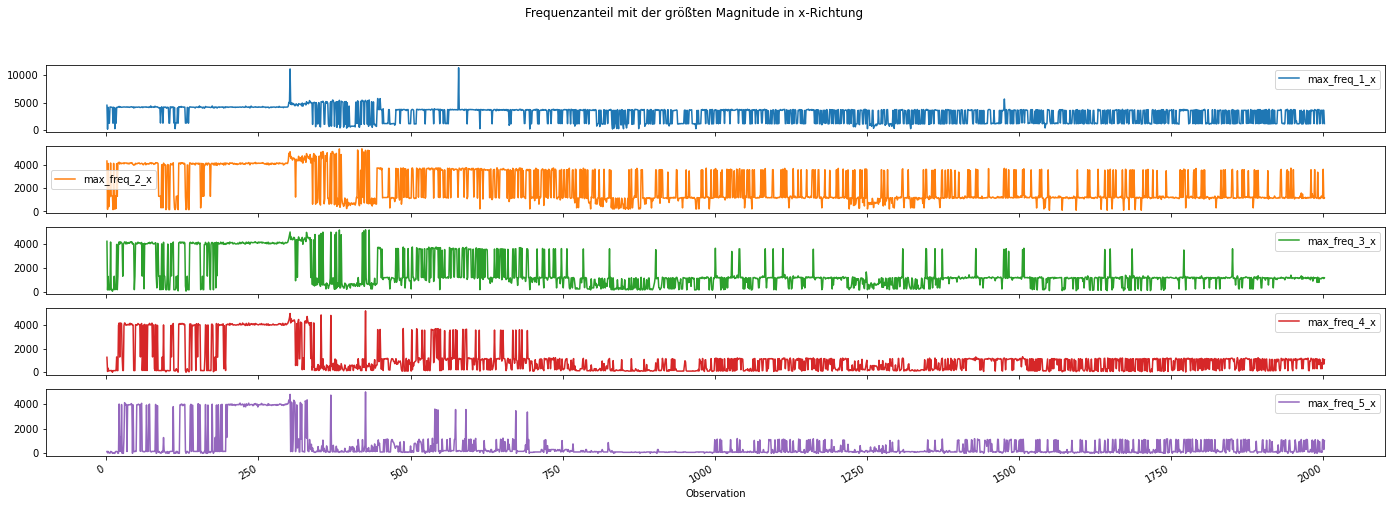

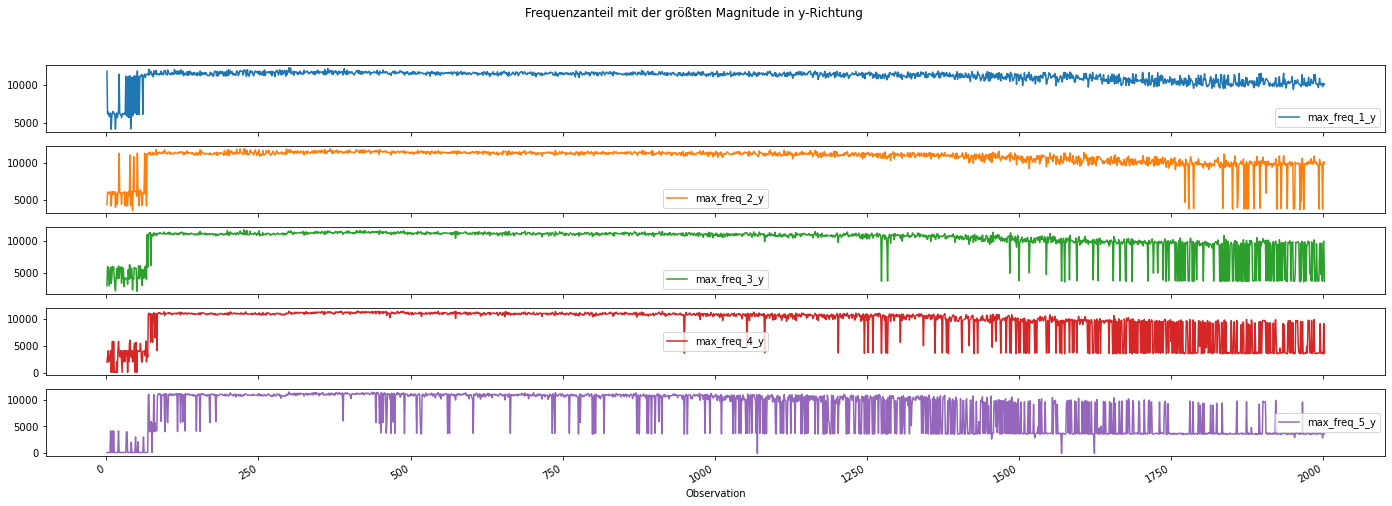

In [40]:
plot_frequencies(data)

<h5>Bearing 2_6 (Testset)</h5>

In [41]:
file = os.path.join(path, 'Test_set', 'Bearing2_6')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing2_6'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 8.691190958023071



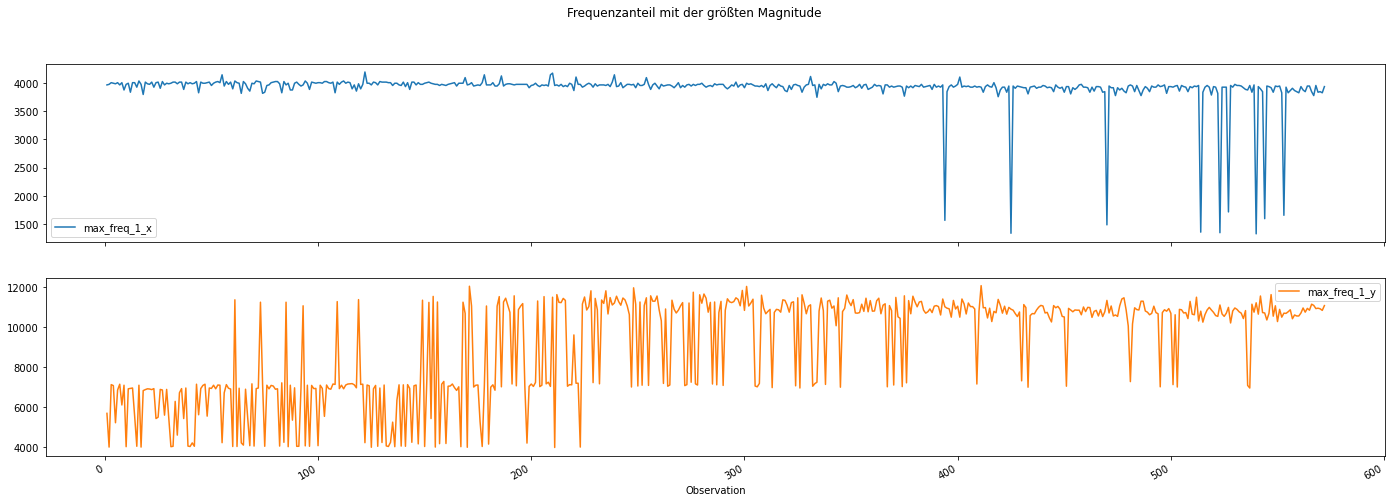

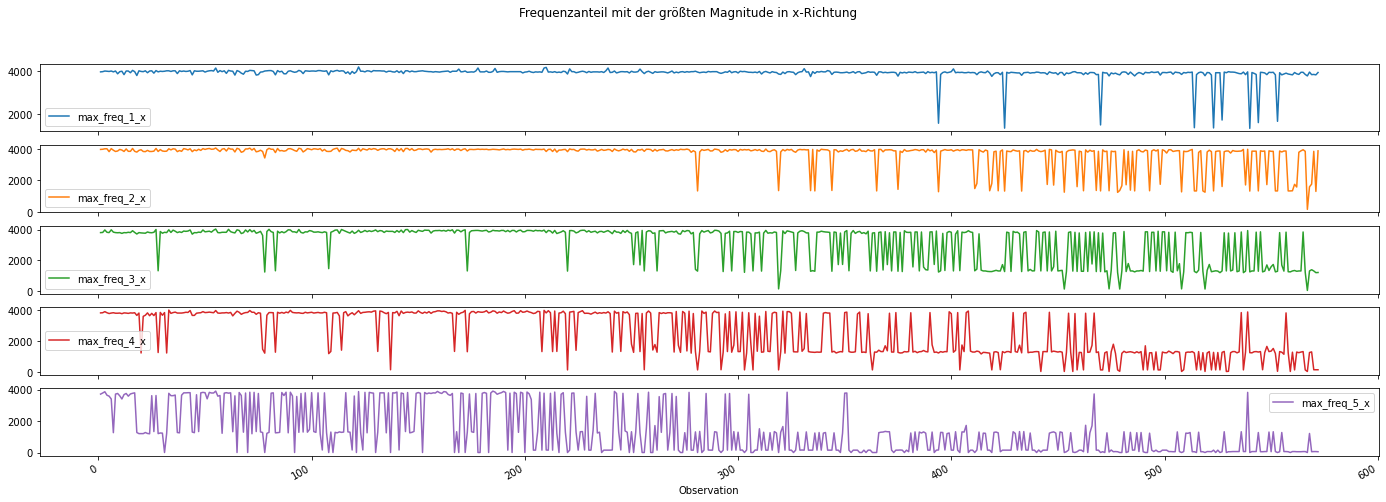

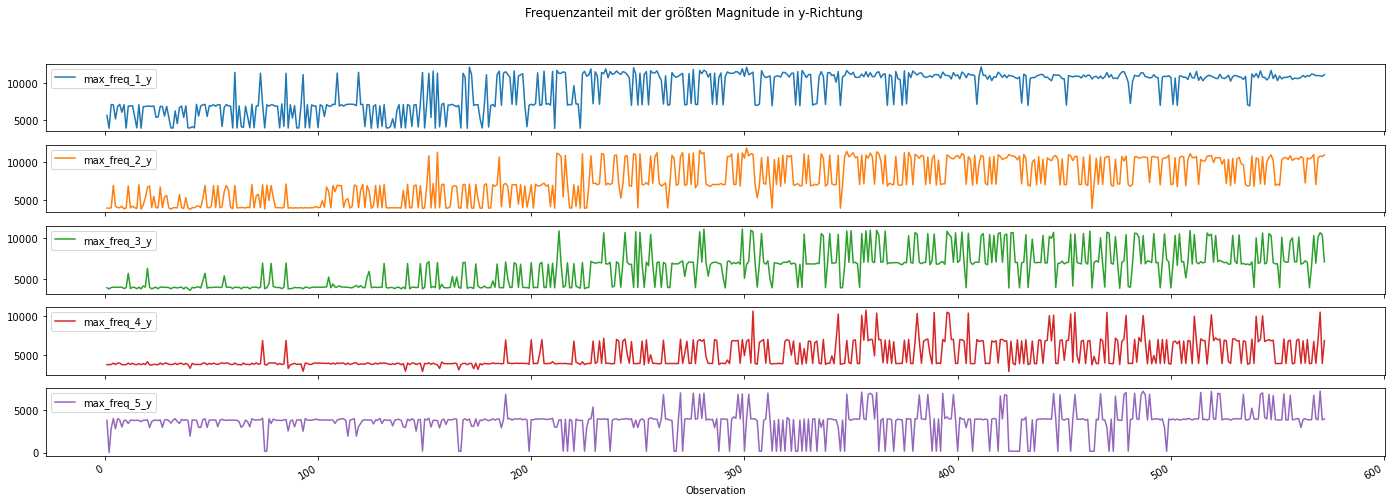

In [42]:
plot_frequencies(data)

<h5>Bearing 2_7 (Testset)</h5>

In [43]:
file = os.path.join(path, 'Test_set', 'Bearing2_7')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing2_7'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 2.888328790664673



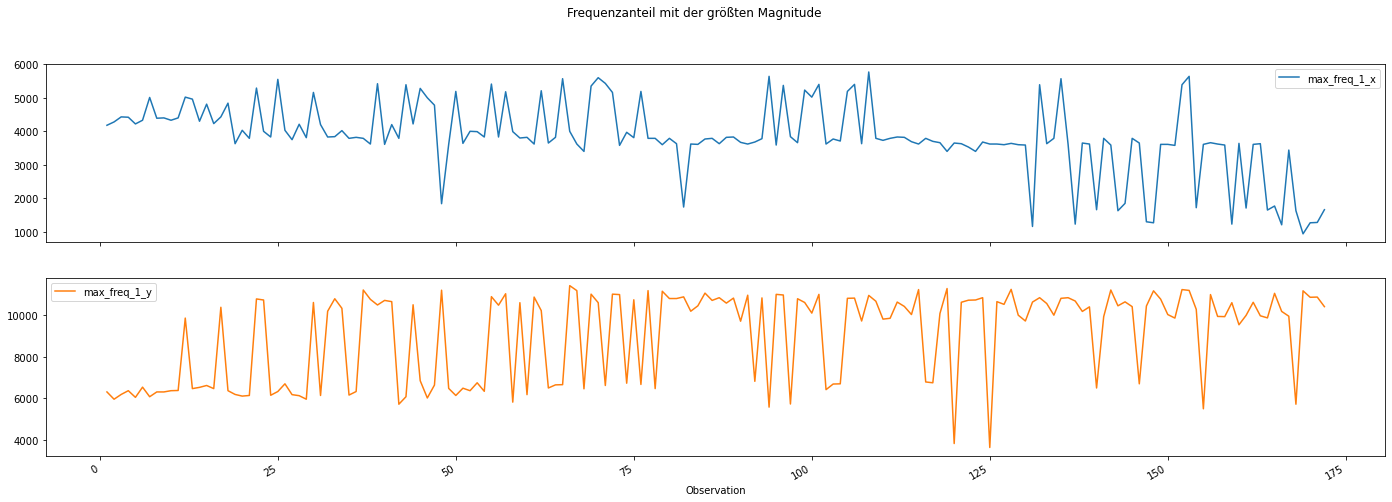

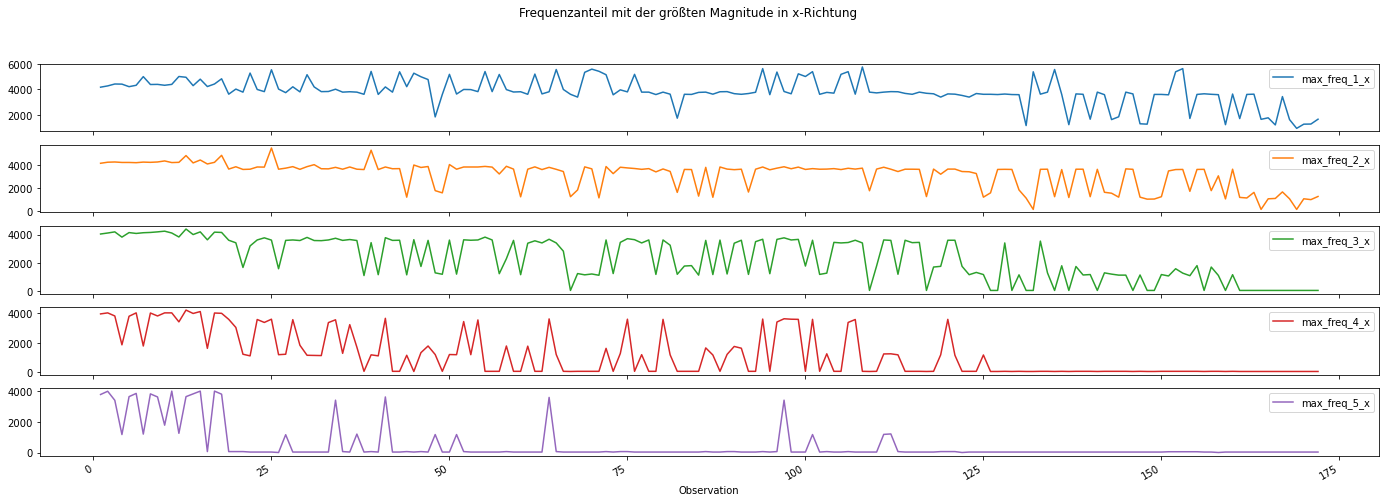

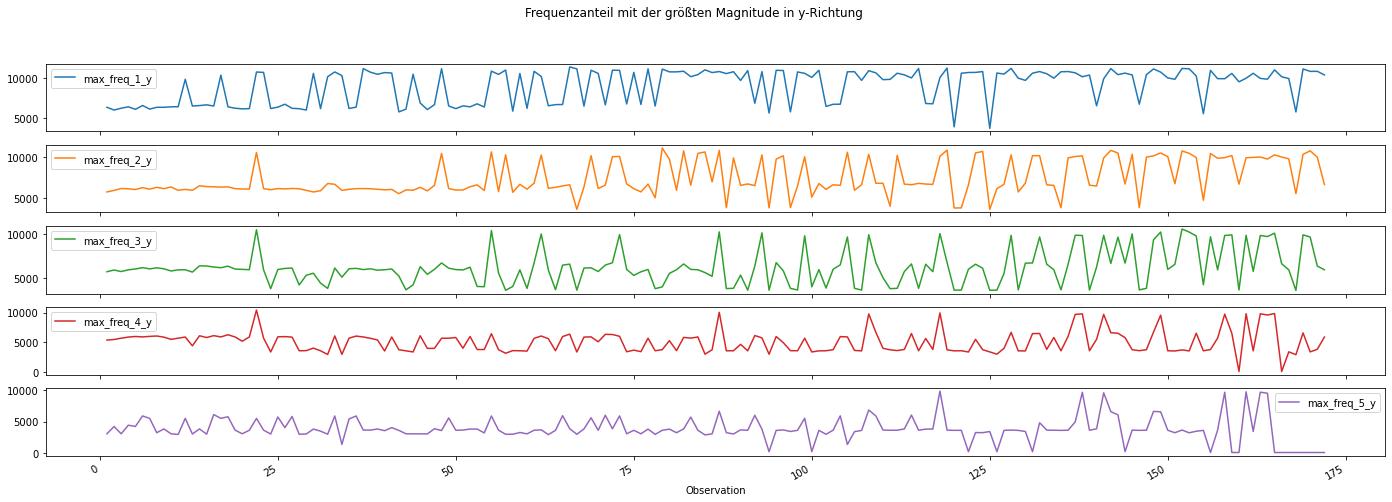

In [44]:
plot_frequencies(data)

<h3>Condition 3</h3>

<h5>Bearing 3_1 (Lernset)</h5>

In [45]:
file = os.path.join(path, 'Learning_set', 'Bearing3_1')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=learning_sets['Bearing3_1'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 8.6004159450531



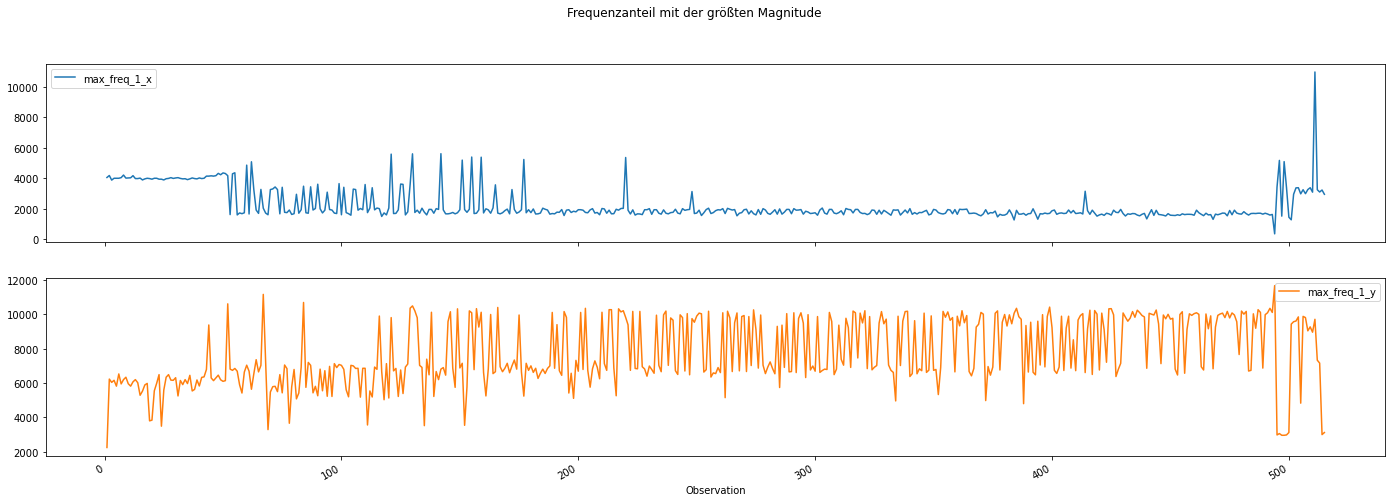

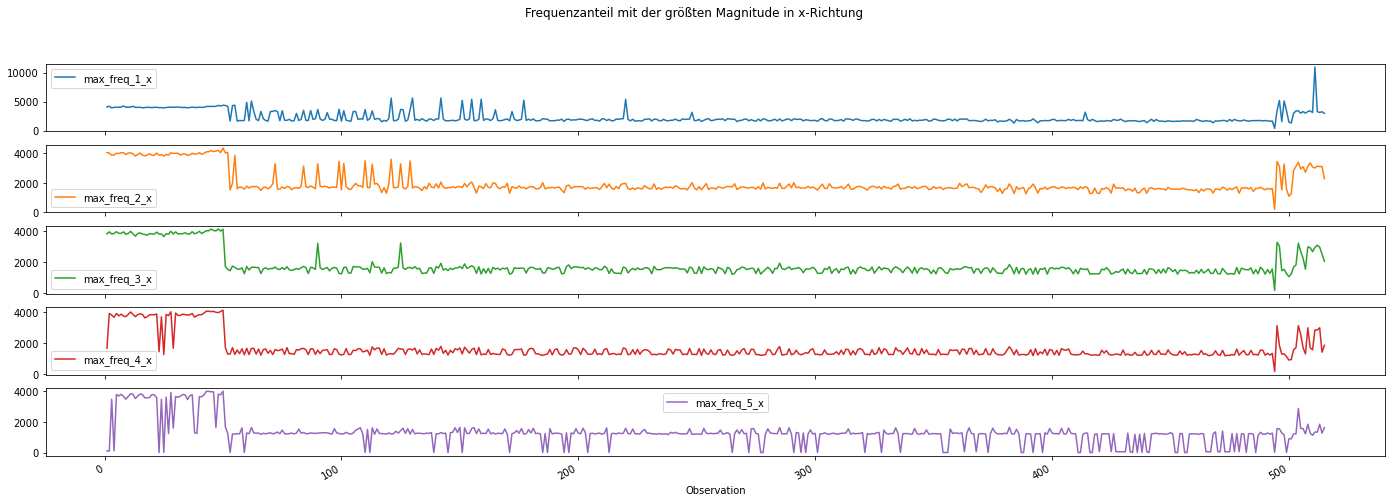

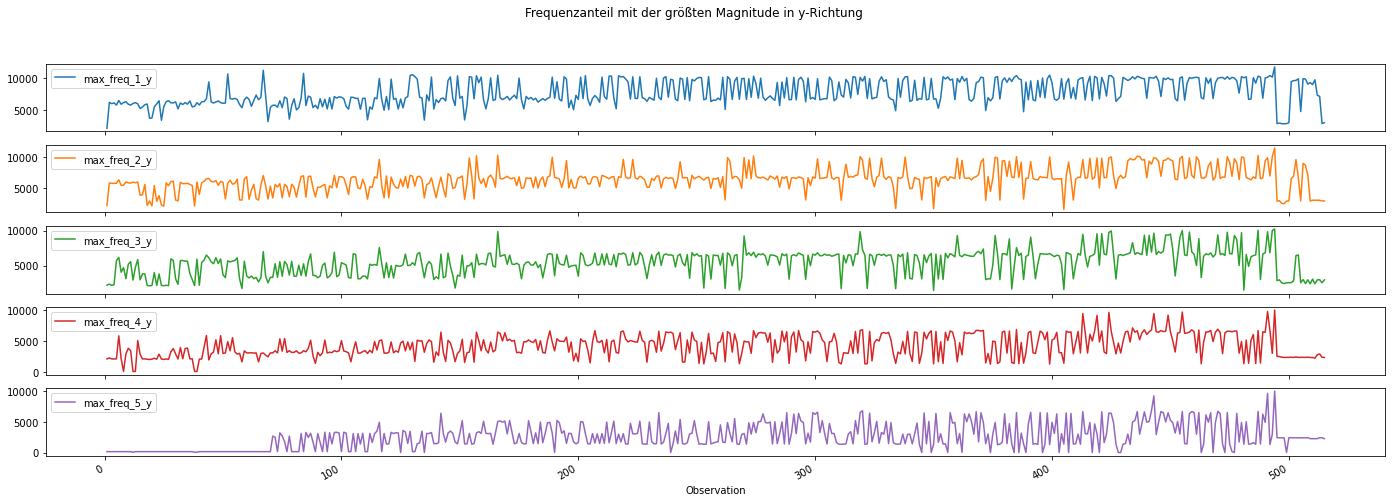

In [46]:
plot_frequencies(data)

<h5>Bearing 3_2 (Lernset)</h5>

In [47]:
file = os.path.join(path, 'Learning_set', 'Bearing3_2')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=learning_sets['Bearing3_2'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 25.34778594970703



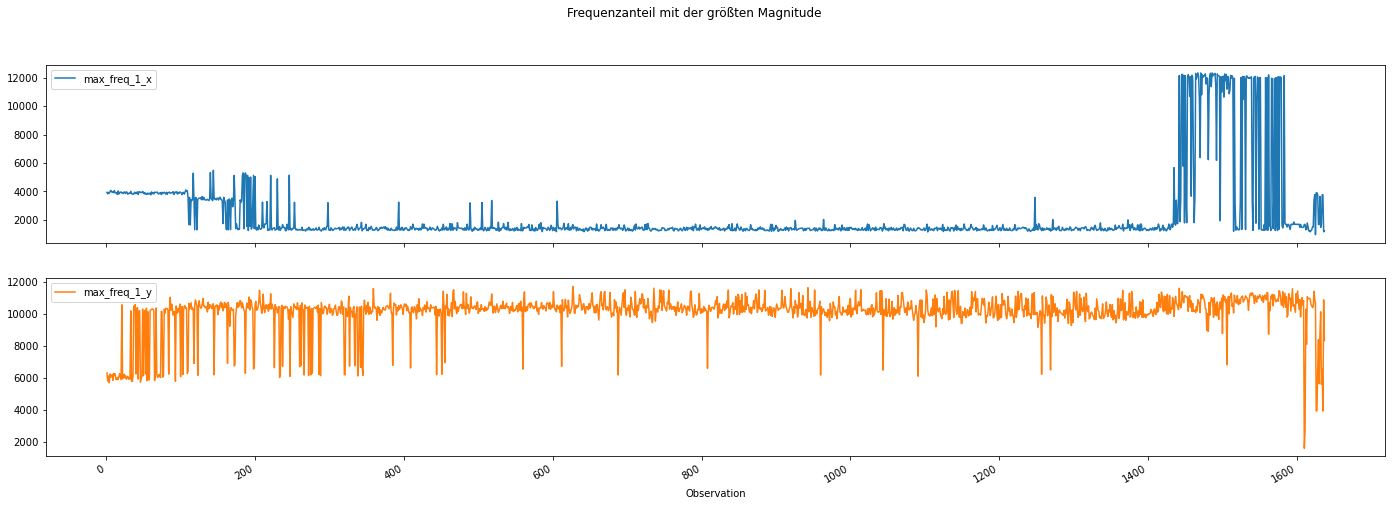

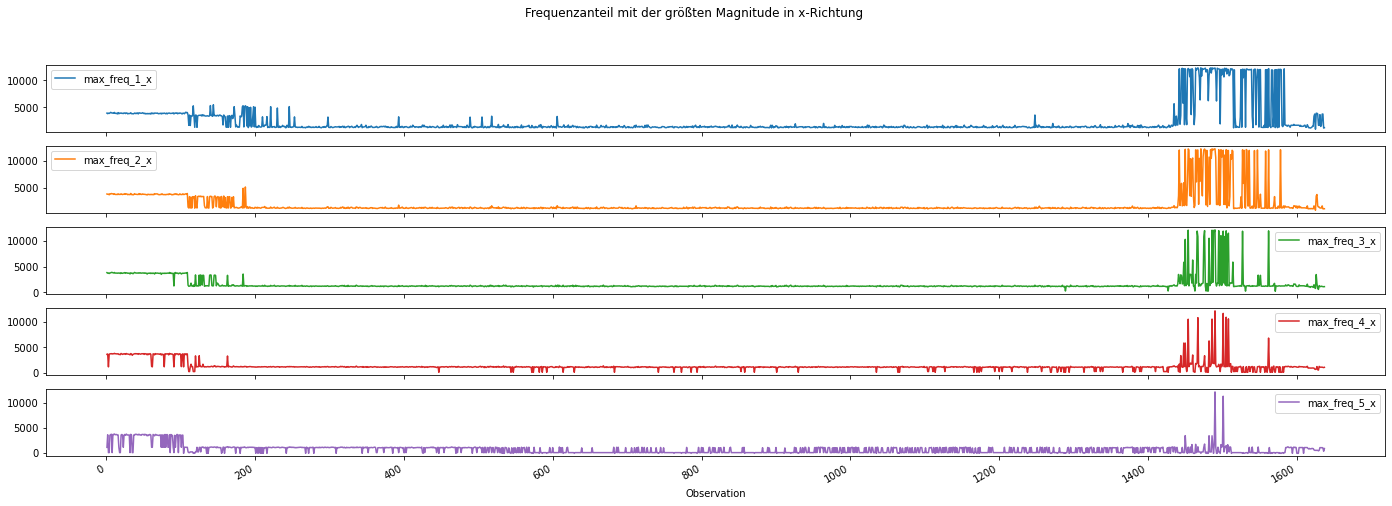

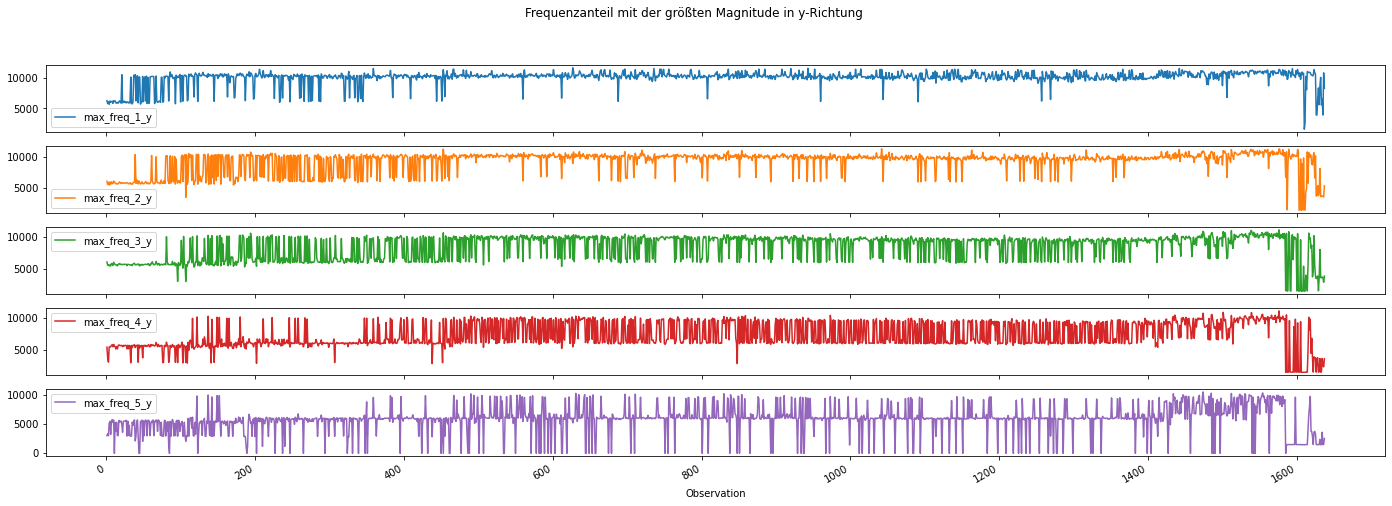

In [48]:
plot_frequencies(data)

<h5>Bearing 3_3 (Testset)</h5>

In [49]:
file = os.path.join(path, 'Test_set', 'Bearing3_3')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing3_3'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
# print_df_infos(data)

Execution Time [s]: 5.602511405944824



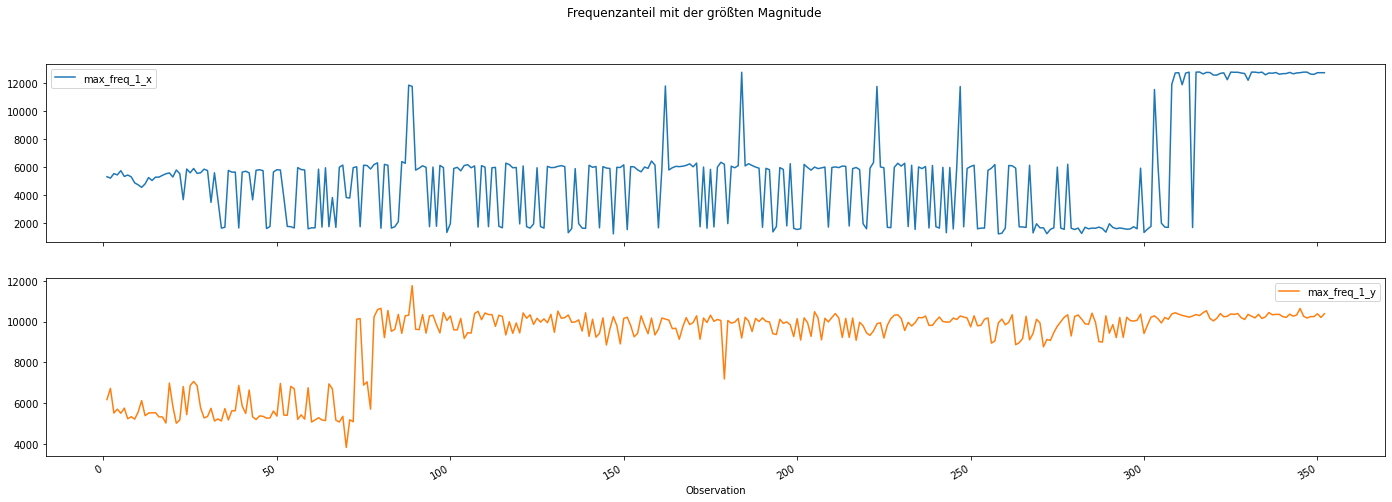

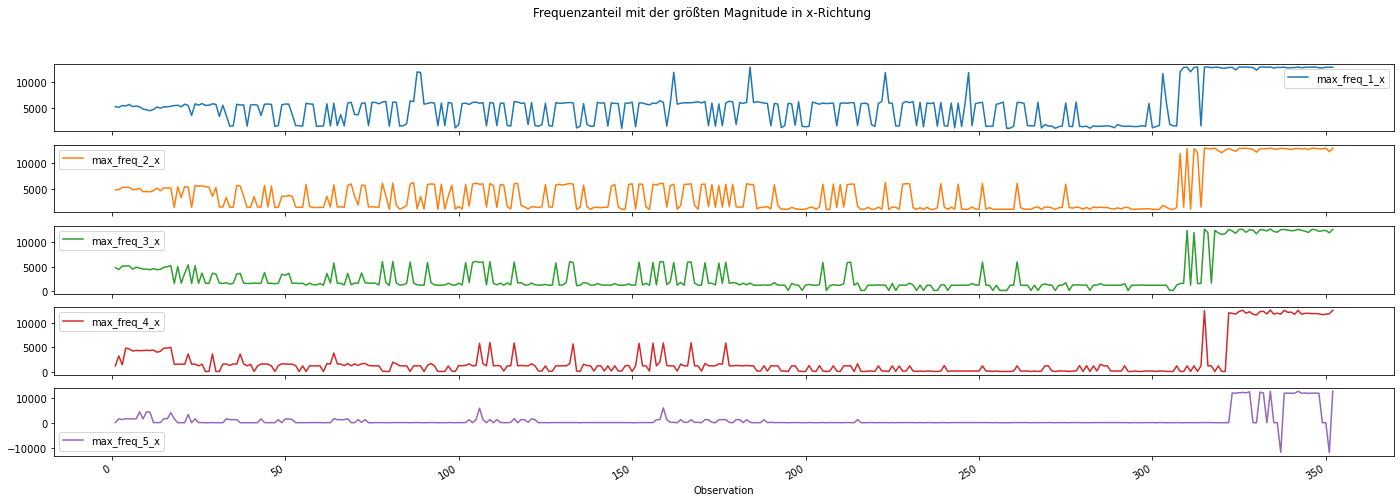

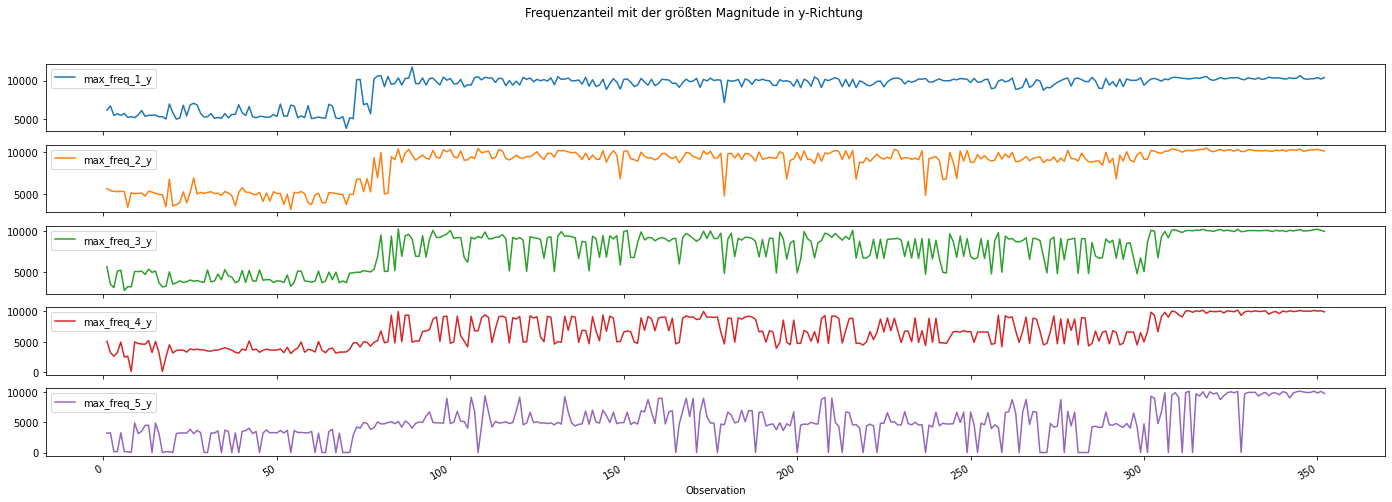

In [50]:
plot_frequencies(data)